### This script contains all the codes to repoduce main and supplementary figures in the manuscript.

In [1]:
import os,sys,warnings,re,itertools,random
random.seed(4444)

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import scipy    
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
from scipy import stats
from scipy.interpolate import make_interp_spline, BSpline
import pybedtools

import sklearn
from sklearn.preprocessing import StandardScaler
from scikit_posthocs import posthoc_tukey
#from statannotations.Annotator import Annotator # i thnk only in spec env

from IPython.display import Image, display

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
import matplotlib.font_manager
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns

### 0. Housekeeping

In [2]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
os.getcwd()

'/Users/yiqiao/Desktop/CRXHD_epigenome_GitHubSubmissino'

In [4]:
# set the parent directory as the working directory
# compatible naming between WinOS and MacOS
base_dir = os.getcwd()
sys.path.insert(0, os.path.join(os.getcwd(),"utils"))

In [5]:
from utils import specseq_plot_utils, specseq_ewm_utils, chipseq_plot_utils, chipseq_annotation_utils, rnaseq_plot_utils, specseq_predict_occp
specseq_plot_utils.set_manuscript_params()

Fontconfig warning: ignoring UTF-8: not a valid region tag


In [7]:
# set up directory variables
# Coopseq data
coop_basedir = os.path.join(base_dir, "Coopseq_analysis", "processed_data")
# CRX & Aldiri ATAC data
atac_basedir = os.path.join(base_dir,"ATACseq_analysis","processed_data")
# CRX ChIP data
chip_basedir = os.path.join(base_dir,"ChIPseq_analysis","processed_data")
# CRX & Aldiri RNA data
rna_basedir = os.path.join(base_dir,"RNAseq_analysis","processed_data")
# luciferase data
luc_dir = os.path.join(base_dir,"luciferase")
# figure output directory
outbase_dir = os.path.join(base_dir, "Figures")

In [8]:
# initialize color palettes
# heatmap color scheme
div_heat_colors = mpl.colors.LinearSegmentedColormap.from_list(
                        "yq_divergent", [(0, "#CF8B03"), (0.5, "#FFFFFF"), (1, "#08306B")])
single_heat_colors = mpl.colors.LinearSegmentedColormap.from_list(
                        "yq_single", [(0, "#D5DCE6"), (1, "#08306B")])

atac_heat_colors = mpl.colors.LinearSegmentedColormap.from_list(
                        "yq_atac", [(0, "#D5DCE6"), (1, "#7A4988")]) 

chip_heat_colors = mpl.colors.LinearSegmentedColormap.from_list(
                        "yq_chip", [(0, "#D5DCE6"), (1, "#08306B")]) 
                        
# label name helper lists
pretty_names = pd.Series({"wt":"WT","ehet":"E80A/+","ehom":"E80A/A","khet":"K88N/+","khom":"K88N/N","rhom":"R90W/W",
                         "at":"E80A/+","aa":"E80A/A","nt":"K88N/+","nn":"K88N/N","ww":"R90W/W",
                         "e80a":"E80A/A", "k88n":"K88N/N", "r90w":"R90W/W"})

delta_unicode = "\u0394"

aldiri_refNum=str(28)

### read data

In [9]:
# Coop-seq
all_genotype_p3p5_coop_df = pd.read_csv(os.path.join(coop_basedir, f"allgenotypes_p3p5_matched_cooperativity.tsv"), sep="\t", header=0)
all_genotype_p3p5_coop_df = all_genotype_p3p5_coop_df.rename(columns={all_genotype_p3p5_coop_df.columns[0]:"sequence"}).set_index("sequence")

In [10]:
# ATAC-seq
e80a_atac_intersect_df = pd.read_csv(os.path.join(atac_basedir, "atac_e80a_readsInPeakNormed.compiled_matrix.intersect_chip.tsv"), sep="\t", header=0)
k88n_atac_intersect_df = pd.read_csv(os.path.join(atac_basedir, "atac_k88n_readsInPeakNormed.compiled_matrix.intersect_chip.tsv"), sep="\t", header=0)

# de novo found motifs from differential accessible peaks
atac_meme_pwms = specseq_ewm_utils.read_meme_files(os.path.join(atac_basedir,"atacEnrichedMotifs.meme"))
atac_meme_stats = pd.Series({
    "Ehom_atacGain.STREME-1": "3.3e-015",
    "Ehom_atacLost.STREME-1": "2.9e-005",
    "Khom_atacGain.STREME-1": "1.3e-043",
    "Khom_atacGain.STREME-2": "1.5e-036",
    "Khom_atacGain.STREME-7": "1.5e-008",
    "Khom_atacLost.STREME-1": "1.1e-010",
    "Khet_atacGain.STREME-1": "4.8e-016",
})

# known retinal transcription factor motifs
prtf_meme_pwms = specseq_ewm_utils.read_meme_files(os.path.join(atac_basedir,"atacPhotoreceptorMotif.meme"))
prtf_meme_ewms = prtf_meme_pwms.apply(lambda x: specseq_ewm_utils.pwm_to_ewm(x, pseudocount=0.0001, temp=25, normalize=False))


reading pwm for Ehet_atacGain.STREME-1
reading pwm for Ehet_atacGain.STREME-4
reading pwm for Ehom_atacGain.STREME-1
reading pwm for Ehom_atacGain.STREME-3
reading pwm for Ehom_atacGain.MEME-7
reading pwm for Ehom_atacLost.MEME-5
reading pwm for Ehom_atacLost.STREME-1
reading pwm for Khet_atacGain.MEME-3
reading pwm for Khet_atacGain.STREME-1
reading pwm for Khet_atacLost.STREME-2
reading pwm for Khom_atacGain.MEME-3
reading pwm for Khom_atacGain.MEME-7
reading pwm for Khom_atacGain.STREME-1
reading pwm for Khom_atacGain.STREME-2
reading pwm for Khom_atacGain.STREME-6
reading pwm for Khom_atacGain.STREME-7
reading pwm for Khom_atacLost.STREME-1
reading pwm for Khom_atacLost.STREME-7
reading pwm for CRX_Corbo
reading pwm for VSX2.MA0726.1
reading pwm for RAX2.MA0717.1
reading pwm for VSX2_e14.5.MEME-1
reading pwm for K88N_chipGain.MEME.1
reading pwm for RORB_HUMAN.MA1150.1
reading pwm for NRL_HUMAN.MA0842.1
reading pwm for Nr2e3_MOUSE.MA0164.1
reading pwm for GFI1_MOUSE.H11MO.0.C
readin

In [11]:
# Published data
# CRX ChIPseq from Zheng 2023
crx_chip_clustered_matrix = pd.read_csv(os.path.join(chip_basedir, "lfc_cutoff_clustered_chip_regions.tsv"), sep="\t", header=0).astype(object)
crx_chip_rna_matrix = pd.read_csv(os.path.join(rna_basedir, "wt_chip_rna_compiled_matrix.txt"), sep="\t", header=0).astype(object).drop_duplicates(subset=["seqnames","start"]).copy()

# RNAseq from Zheng 2023
crx_rna_full_matrix = pd.read_csv(os.path.join(rna_basedir, "compiled_hdmuts_lfc.tsv"), sep="\t", header=0).astype(object)

# CRX dependent CRE type annotation - in chip_diffbind_motif_diffenrich.ipynb
unique_gene_motif = pd.read_csv(os.path.join(rna_basedir, "crx_all_target_genes_cre_group_annotation.tsv"), sep="\t", header=0)
k50_gene_annot = pd.read_csv(os.path.join(rna_basedir, "crx_all_target_genes_k50_motif_annotation.tsv"), sep="\t", header=0)

# ATACseq from Aldiri 2017 scored against e80a and k88n atac consensus peaksets
e80a_atac_aldiri = pd.read_csv(os.path.join(atac_basedir, "aldiri_atac_e80a_consensus_peaks.NativeNormed.tsv"), sep="\t", header=0)
k88n_atac_aldiri = pd.read_csv(os.path.join(atac_basedir, "aldiri_atac_k88n_consensus_peaks.NativeNormed.tsv"), sep="\t", header=0)

# RNAseq from Aldiri 2017
aldiri_rna_normalized_counts = pd.read_csv(os.path.join(rna_basedir, "aldiri_rna_normalized_counts.tsv"), sep="\t", header=0).astype(object)

# VSX2 ChIPseq from Bian 2022
vsx2_consensus_peakset =pd.read_csv(os.path.join(chip_basedir, "vsx2_chip_clustered_regions.tsv"), sep="\t", header=0)

In [12]:
# luciferase
luciferase_df = pd.read_csv(os.path.join(luc_dir, "BAT1_luciferase.csv"), sep=",", header=0).astype(object)

### I. luciferase reporter assay

In [12]:
# prepare the data
luciferase_df = pd.melt(luciferase_df, id_vars=["protein", "reporter"], value_vars=["rep1", "rep2", "rep3", "rep4"], var_name="rep", value_name="fc")

F_onewayResult(statistic=23.17502834609822, pvalue=0.00028187721847917083)


,index,variable,value
3,hisC,wt,0.463658
6,hisC,k88n,0.001000
7,wt,k88n,0.001498


F_onewayResult(statistic=143.92052461386984, pvalue=1.4714092486106304e-07)


,index,variable,value
3,hisC,wt,0.001
6,hisC,k88n,0.001
7,wt,k88n,0.001


F_onewayResult(statistic=nan, pvalue=nan)


,index,variable,value
3,hisC,wt,0.900000
6,hisC,k88n,0.547723
7,wt,k88n,0.479023


F_onewayResult(statistic=121.71843426063785, pvalue=3.050729937912532e-07)


,index,variable,value
3,hisC,wt,0.001000
6,hisC,k88n,0.002349
7,wt,k88n,0.001000


F_onewayResult(statistic=6.688740677480869, pvalue=0.016593609850481847)


,index,variable,value
3,hisC,wt,0.900000
6,hisC,k88n,0.020806
7,wt,k88n,0.039494


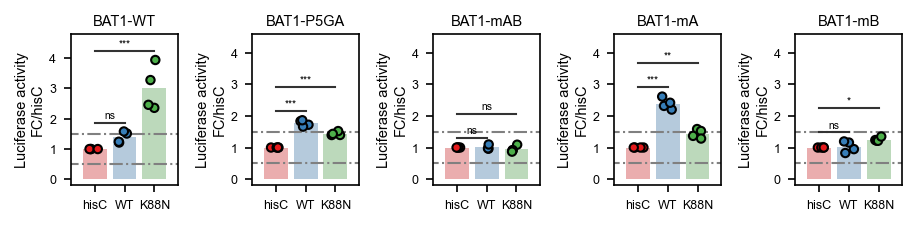

In [14]:
# anova version
fig,ax_list = plt.subplots(ncols=5, figsize=(6,1.4), dpi=150, constrained_layout=True, gridspec_kw=dict(wspace=.1))

for reporter, ax in zip(luciferase_df.reporter.unique(), ax_list):
    data_to_plot = luciferase_df.copy().loc[lambda df: df["reporter"] == reporter, :].reset_index(drop=True) # 

    ax = sns.stripplot(x="protein", y="fc", data=data_to_plot,
                       palette="Set1", edgecolor="black", 
                       dodge=False, linewidth=1, marker="o", size=4, jitter=.2, ax=ax)
    #ax = sns.boxplot(x="protein", y="fc", data=data_to_plot, whis=np.inf, palette="Set2", ax=ax)
    ax = sns.barplot(data=data_to_plot, x="protein", y="fc", 
                     palette="Set1", alpha=.4, ci=None, ax=ax)

    # decorations
    ax.set_ylim(-.2,4.6)
    ax.set_yticks([0,1.0,2.0,3.0,4.0])
    ax.set_xlim(-.8,2.8)
    ax.set(xlabel="", ylabel=f"Luciferase activity\nFC/hisC")
    ax.set_xticklabels(["hisC","WT","K88N"])
    ax.set_title(f"{reporter}")

    ax.axhline(y=.5, xmin=-.9, xmax=3.8, linewidth=1, linestyle="-.", color="grey")
    ax.axhline(y=1.5, xmin=-.9, xmax=3.8, linewidth=1, linestyle="-.", color="grey")

    # compute statistics and add annotation to plot
    # do two-way ANOVA with Tukey HSD and store p-values for manual annotation
    # transform data to array-like data
    gb = data_to_plot.groupby("protein")
    data_to_anova = [data_to_plot.groupby("protein").get_group(x).fc.to_list() for x in data_to_plot.groupby("protein").groups]
    # print one-way ANOVA F statistics
    print(stats.f_oneway(*data_to_anova))
    # Turkey test
    tukey_df = posthoc_tukey(data_to_plot, val_col="fc", group_col="protein")
    # tidy up Turkey test results
    remove = np.tril(np.ones(tukey_df.shape), k=0).astype("bool")
    tukey_df[remove] = np.nan
    molten_df = tukey_df.melt(ignore_index=False).reset_index().dropna()
    molten_df
    # print Turkey test result table
    display(molten_df)
    # retrieve p-values between mutant-wt comparison for plotting
    pairs = [(i[1]["index"], i[1]["variable"]) for i in molten_df.iterrows() if i[1]["index"]=="hisC"]
    p_values = [i[1]["value"] for i in molten_df.iterrows() if i[1]["index"]=="hisC"]

    # only plot p-values compared to WT
    annotator = Annotator(
        ax, pairs, y="fc", x="protein", data=data_to_plot, orient='v', order=["hisC", "wt", "k88n"], verbose=0
    )
    annotator.configure(text_format='star', loc='inside', line_width=mpl.rcParams["lines.linewidth"], line_height=0.0, verbose=0)
    annotator.set_pvalues_and_annotate(p_values)

In [15]:
specseq_plot_utils.save_fig(fig, prefix=os.path.join(outbase_dir, "manuscript", "figure1_luciferase"), timestamp=False, tight_layout=False)

### II. Coop-seq

found BAT1


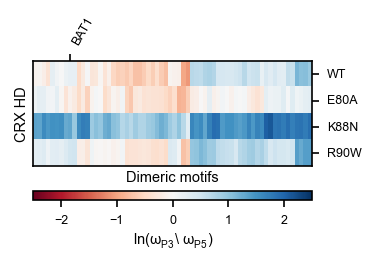

In [13]:
fig, ax = plt.subplots(figsize=(2.4,1.2), dpi=150)

vmin=-2.5
vmax=2.5
thresh = 1
# reorder the PCC dataframe
data_to_plot = all_genotype_p3p5_coop_df.loc[:,lambda df: df.columns[df.columns.str.contains("delta")]].copy()

# clustering
reponsive_CRE_to_plot_cg = chipseq_plot_utils.chip_intensity_heatmap(data=data_to_plot,
                                                                        hm_title=None, hm_xlabel=None, cb_title=None, cmap=div_heat_colors, 
                                                                        paramdict=dict(
                                                                        z_score=None,
                                                                        method="complete",
                                                                        metric="euclidean",
                                                                        #method="ward",
                                                                        #metric="correlation"
                                                                    ))
new_order = reponsive_CRE_to_plot_cg.dendrogram_row.reordered_ind
plt.close()
# reorder the differential expression dataframe based on clustering
data_to_plot = data_to_plot.iloc[new_order,:].iloc[::-1].T #

# rank by one hd
#data_to_plot = data_to_plot.sort_values(by="k88n.delta.ln.omega", ascending=True).T

heatmap = ax.imshow(data_to_plot, aspect="auto", vmin=vmin, vmax=vmax, cmap="RdBu")
ax.xaxis.tick_top() 
#ax.set_xticks(np.arange(len(data_to_plot.columns)))
#ax.set_xticklabels(data_to_plot.columns, rotation=90, ha="center")
ax.set_xticks([])
# annotate only the BAT1 column
for i,seq in enumerate(data_to_plot.columns):
   if seq == "TAATCATATTA":
       print("found BAT1")
       ax.set_xticks([i],["BAT1"], rotation=60, ha="left")
       break

ax.yaxis.tick_right()
ax.set_yticks(np.arange(len(data_to_plot.index)))
ax.set_yticklabels(["WT", "E80A", "K88N", "R90W"], va="center")
ax.set_xlabel(f"Dimeric motifs")
ax.set_ylabel(f"CRX HD")

#specseq_plot_utils.annotate_heatmap(ax, data_to_plot.T, thresh)

# Add a colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="8%", pad="24%")
colorbar = fig.colorbar(heatmap, cax=cax, orientation="horizontal", label="ln(\u03C9$_{P3}$\\ \u03C9$_{P5}$)")

In [19]:
# export the clustered and sorted dataframe to be included as supplementary table
data_to_plot.T.to_csv(os.path.join(coop_basedir, "clustered_sorted_deltap3p5_cooperativity.tsv"), sep="\t", header=0, index=True)

In [10]:
specseq_plot_utils.save_fig(fig, prefix=os.path.join(outbase_dir, "manuscript", "figure2_cooperativity_p3p5_matched"), timestamp=False, tight_layout=False)

In [26]:
data_to_plot

sequence,TAATCAAATTA,TAATTAAATTA,TAATTACATTA,TAATGGAATTA,TAATGATATTA,TAATGAAATTA,TAATTAGATTA,TAATCTGATTA,TAATCATATTA,TAATATCATTA,...,TAATGGCATTA,TAATGCCATTA,TAATGGTATTA,TAATTCCATTA,TAATGGGATTA,TAATGACATTA,TAATCGCATTA,TAATGAGATTA,TAATAAGATTA,TAATGCGATTA
wt.delta.ln.omega,-0.084428,-0.072603,-0.163512,-0.358895,0.223282,0.078561,0.014981,0.152064,0.199990,0.204481,...,0.287230,0.427016,0.276188,0.264659,0.613121,0.559309,1.138909,1.048133,1.073071,0.936070
e80a.delta.ln.omega,0.104161,0.227971,0.227145,0.087394,0.066727,0.240899,-0.047938,-0.349789,-0.098903,-0.215481,...,0.123907,0.174122,0.173777,0.310150,0.050129,0.295422,0.100393,0.156251,0.238333,0.269815
k88n.delta.ln.omega,1.338739,1.325153,1.577624,1.434862,1.519646,1.484496,1.535383,1.262129,1.296331,0.941675,...,2.111211,1.816082,1.854463,1.738588,1.882790,1.705421,1.827834,1.852769,1.746804,1.890624
r90w.delta.ln.omega,0.242704,0.259875,0.331466,0.126992,0.261090,0.275356,0.227115,0.342794,0.453544,0.504333,...,0.397392,0.511204,0.443884,0.432092,0.375676,0.492685,1.381887,1.253489,1.381567,1.370181


found BAT1


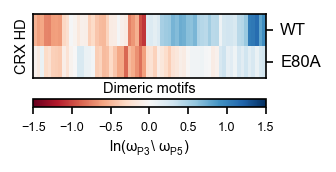

In [14]:
fig, ax = plt.subplots(figsize=(2,.8), dpi=150)

vmin=-1.5
vmax=1.5
thresh = 1
# reorder the PCC dataframe
data_to_plot = all_genotype_p3p5_coop_df.loc[:,lambda df: df.columns[df.columns.str.contains("delta")]].copy()

# clustering
reponsive_CRE_to_plot_cg = chipseq_plot_utils.chip_intensity_heatmap(data=data_to_plot[["wt.delta.ln.omega","e80a.delta.ln.omega"]],
                                                                        hm_title=None, hm_xlabel=None, cb_title=None, cmap=div_heat_colors, 
                                                                        paramdict=dict(
                                                                        z_score=None,
                                                                        method="complete",
                                                                        metric="euclidean",
                                                                        #method="ward",
                                                                        #metric="correlation"
                                                                    ))
new_order = reponsive_CRE_to_plot_cg.dendrogram_row.reordered_ind
plt.close()
# reorder the differential expression dataframe based on clustering
data_to_plot = data_to_plot.iloc[new_order,:].iloc[::-1].T #

# rank by one hd
#data_to_plot = data_to_plot.sort_values(by="k88n.delta.ln.omega", ascending=True).T

heatmap = ax.imshow(data_to_plot.iloc[[0,1],:], aspect="auto", vmin=vmin, vmax=vmax, cmap="RdBu")
ax.xaxis.tick_top() 
#ax.set_xticks(np.arange(len(data_to_plot.columns)))
#ax.set_xticklabels(data_to_plot.columns, rotation=90, ha="center")
ax.set_xticks([])
# annotate only the BAT1 column
for i,seq in enumerate(data_to_plot.columns):
   if seq == "TAATCATATTA":
       print("found BAT1")
       #ax.set_xticks([i],["BAT1"], rotation=60, ha="left")
       break

ax.yaxis.tick_right()
ax.set_yticks(np.arange(2))
ax.set_yticklabels(["WT", "E80A"], va="center", fontsize=8)
ax.set_xlabel(f"Dimeric motifs")
ax.set_ylabel(f"CRX HD")

#specseq_plot_utils.annotate_heatmap(ax, data_to_plot.T, thresh)

# Add a colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="12%", pad="34%")
colorbar = fig.colorbar(heatmap, cax=cax, orientation="horizontal", label="ln(\u03C9$_{P3}$\\ \u03C9$_{P5}$)")

In [22]:
specseq_plot_utils.save_fig(fig, prefix=os.path.join(outbase_dir, "RADseminar_e80awt_coop"), timestamp=False, tight_layout=False)


### III. E80A vs WT ATAC seq

In [15]:
# display percentage of differential ATAC peaks
e80a_atac_intersect_df["aa_atac_cluster"].value_counts()/len(e80a_atac_intersect_df)

aa_atac_cluster
aa.atac.notDA    0.981846
aa.atac.gain     0.014089
aa.atac.lost     0.004065
Name: count, dtype: float64

#### ATACseq intensity heatmap - re-arrangement of deeptools heatmaps

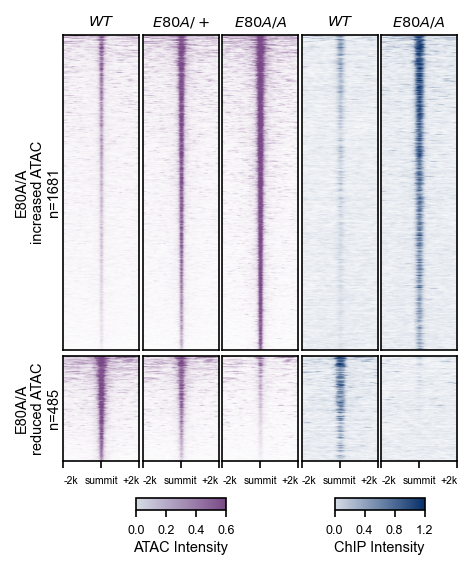

In [16]:
## DEEPTOOLS HEATMAP with MEME MOTIFS
aa_atac_heatmap_dir = os.path.join(outbase_dir, "heatmaps", "aa_images", "600ppi")

# set up the figure
fig = plt.figure(figsize=(3,4), dpi=150) #constrained_layout=True, 
gs = fig.add_gridspec(nrows=4, ncols=6, width_ratios=[.1,1,1,1,1,1], height_ratios=[.1,3,1,.3])
gs.update(left=.05,right=.95,top=.9,bottom=.1,wspace=0.05,hspace=0.05) #padding for each grid space

peak_order = ["gain","lost"]
peak_label = ["increased", "reduced"]
peak_num = [1681,485]
labels = [ "wt_atac", "ehet_atac", "ehom_atac", "wt_chip", "e80a_chip"]
for i,peak, in enumerate(peak_order):
    # first add the cluster label
    text_ax = fig.add_subplot(gs[i+1, 0])
    text_ax.set_frame_on(False)
    text_ax.set_axis_off()
    text_ax.text(-.8, .5, f"E80A/A\n{peak_label[i]} ATAC\nn={str(peak_num[i])}\n", rotation=90, 
                 fontsize=mpl.rcParams["axes.labelsize"], va='center', ha='center')
    for j in range(5):
        ax = fig.add_subplot(gs[i+1, j+1])
        ax.set_frame_on(True)
        # add genotype label
        if i== 0:
            genotype = labels[j].split("_")[0]
            ax.set_title(f"$\it {pretty_names[genotype]}$")
        # get the width and height of axes box
        bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        width, height = bbox.width, bbox.height
        width *= fig.dpi
        height *= fig.dpi
        # read the heatmap image and resize
        img = mpimg.imread(os.path.join(aa_atac_heatmap_dir, f"{labels[j]}_aa_{peak_order[i]}.png"))
        # resize image
        #img = img.resize((int(width), int(height)))
        ax.imshow(img, aspect='auto', extent=(0,1,0,1), origin='upper', transform=ax.transAxes)
        if i < 1: # remove axis and frame if not the bottom row of heatmap
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
        else: # add the dist to submit labels
            ax.yaxis.set_visible(False) # hide y axis
            ax.spines.bottom.set_visible(True)
            ax.xaxis.set_ticks_position('bottom')
            ax.set_xticks([0,int(width)/2,int(width)])
            ax.set_xticklabels(["-2k","summit","+2k"], fontsize=5)
            # align the labels at two ends
            ticklabels = ax.get_xticklabels()
            # set the alignment for outer ticklabels
            ticklabels[0].set_ha("left")
            ticklabels[-1].set_ha("right")

# add experiment labels
atac_text_ax = fig.add_subplot(gs[0,1:4])
#atac_text_ax.text(.5, 2.5, "ATACseq", fontsize=mpl.rcParams["axes.titlesize"], ha="center", va="bottom")
atac_text_ax.axis('off')
#atac_text_ax.axhline(y=2.5, xmin=0, xmax=1, linewidth=1.5, color="k")

chip_text_ax = fig.add_subplot(gs[0,4:6])
#chip_text_ax.text(.5, 2.5, "CRX ChIPseq", fontsize=mpl.rcParams["axes.titlesize"], ha="center", va="bottom")
chip_text_ax.axis('off')
#chip_text_ax.axhline(y=2.5, xmin=0, xmax=1, linewidth=1.5, color="k")


# add a dummy color bar to the bottom of the lower right axes
# get the axes position of the heatmap title and center-align color bar to it
atac_cbar_pos = atac_text_ax.get_position()
atac_cbar_width = 0.2
atac_cbar_ax = plt.axes([(atac_cbar_pos.x0+atac_cbar_pos.x1-atac_cbar_width)/2, 0.08, atac_cbar_width, 0.02])
atac_cbar_ax.set_frame_on(True)
atac_norm = mpl.colors.Normalize(vmin=0, vmax=0.6)
atac_colorbar = fig.colorbar(mpl.cm.ScalarMappable(norm=atac_norm, cmap=atac_heat_colors), ticks=[0.0,0.2,0.4,0.6],
             cax=atac_cbar_ax, orientation='horizontal', label='ATAC Intensity')

chip_cbar_pos = chip_text_ax.get_position()
chip_cbar_width = 0.2
chip_cbar_ax = plt.axes([(chip_cbar_pos.x0+chip_cbar_pos.x1-chip_cbar_width)/2, 0.08, chip_cbar_width, 0.02])
chip_cbar_ax.set_frame_on(True)
chip_norm = mpl.colors.Normalize(vmin=0, vmax=1.2)
chip_colorbar = fig.colorbar(mpl.cm.ScalarMappable(norm=chip_norm, cmap=chip_heat_colors), ticks=[0.0,0.4,0.8,1.2],
             cax=chip_cbar_ax, orientation='horizontal', label='ChIP Intensity')


plt.show()

In [21]:
specseq_plot_utils.save_fig(fig, prefix=os.path.join(outbase_dir, "manuscript", "figure3_e80a_atac_deeptools"), timestamp=False, tight_layout=False)

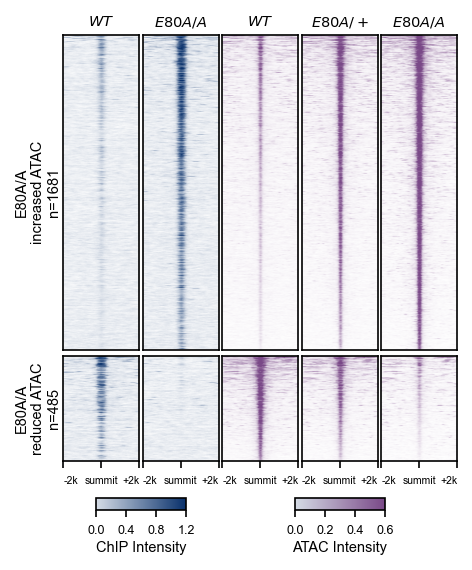

In [17]:
# For interview talk
## DEEPTOOLS HEATMAP with MEME MOTIFS
aa_atac_heatmap_dir = os.path.join(outbase_dir, "heatmaps", "aa_images", "600ppi")

# set up the figure
fig = plt.figure(figsize=(3,4), dpi=150) #constrained_layout=True, 
gs = fig.add_gridspec(nrows=4, ncols=6, width_ratios=[.1,1,1,1,1,1], height_ratios=[.1,3,1,.3])
gs.update(left=.05,right=.95,top=.9,bottom=.1,wspace=0.05,hspace=0.05) #padding for each grid space

peak_order = ["gain","lost"]
peak_label = ["increased", "reduced"]
peak_num = [1681,485]
labels = [ "wt_chip", "e80a_chip","wt_atac","ehet_atac","ehom_atac",]
for i,peak, in enumerate(peak_order):
    # first add the cluster label
    text_ax = fig.add_subplot(gs[i+1, 0])
    text_ax.set_frame_on(False)
    text_ax.set_axis_off()
    text_ax.text(-.8, .5, f"E80A/A\n{peak_label[i]} ATAC\nn={str(peak_num[i])}\n", rotation=90, 
                 fontsize=mpl.rcParams["axes.labelsize"], va='center', ha='center')
    for j in range(5):
        ax = fig.add_subplot(gs[i+1, j+1])
        ax.set_frame_on(True)
        # add genotype label
        if i== 0:
            genotype = labels[j].split("_")[0]
            ax.set_title(f"$\it {pretty_names[genotype]}$")
        # get the width and height of axes box
        bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        width, height = bbox.width, bbox.height
        width *= fig.dpi
        height *= fig.dpi
        # read the heatmap image and resize
        img = mpimg.imread(os.path.join(aa_atac_heatmap_dir, f"{labels[j]}_aa_{peak_order[i]}.png"))
        # resize image
        #img = img.resize((int(width), int(height)))
        ax.imshow(img, aspect='auto', extent=(0,1,0,1), origin='upper', transform=ax.transAxes)
        if i < 1: # remove axis and frame if not the bottom row of heatmap
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
        else: # add the dist to submit labels
            ax.yaxis.set_visible(False) # hide y axis
            ax.spines.bottom.set_visible(True)
            ax.xaxis.set_ticks_position('bottom')
            ax.set_xticks([0,int(width)/2,int(width)])
            ax.set_xticklabels(["-2k","summit","+2k"], fontsize=5)
            # align the labels at two ends
            ticklabels = ax.get_xticklabels()
            # set the alignment for outer ticklabels
            ticklabels[0].set_ha("left")
            ticklabels[-1].set_ha("right")

# add experiment labels
atac_text_ax = fig.add_subplot(gs[0,3:6])
#atac_text_ax.text(.5, 2.5, "ATACseq", fontsize=mpl.rcParams["axes.titlesize"], ha="center", va="bottom")
atac_text_ax.axis('off')
#atac_text_ax.axhline(y=2.5, xmin=0, xmax=1, linewidth=1.5, color="k")

chip_text_ax = fig.add_subplot(gs[0,1:3])
#chip_text_ax.text(.5, 2.5, "CRX ChIPseq", fontsize=mpl.rcParams["axes.titlesize"], ha="center", va="bottom")
chip_text_ax.axis('off')
#chip_text_ax.axhline(y=2.5, xmin=0, xmax=1, linewidth=1.5, color="k")


# add a dummy color bar to the bottom of the lower right axes
# get the axes position of the heatmap title and center-align color bar to it
atac_cbar_pos = atac_text_ax.get_position()
atac_cbar_width = 0.2
atac_cbar_ax = plt.axes([(atac_cbar_pos.x0+atac_cbar_pos.x1-atac_cbar_width)/2, 0.08, atac_cbar_width, 0.02])
atac_cbar_ax.set_frame_on(True)
atac_norm = mpl.colors.Normalize(vmin=0, vmax=0.6)
atac_colorbar = fig.colorbar(mpl.cm.ScalarMappable(norm=atac_norm, cmap=atac_heat_colors), ticks=[0.0,0.2,0.4,0.6],
             cax=atac_cbar_ax, orientation='horizontal', label='ATAC Intensity')

chip_cbar_pos = chip_text_ax.get_position()
chip_cbar_width = 0.2
chip_cbar_ax = plt.axes([(chip_cbar_pos.x0+chip_cbar_pos.x1-chip_cbar_width)/2, 0.08, chip_cbar_width, 0.02])
chip_cbar_ax.set_frame_on(True)
chip_norm = mpl.colors.Normalize(vmin=0, vmax=1.2)
chip_colorbar = fig.colorbar(mpl.cm.ScalarMappable(norm=chip_norm, cmap=chip_heat_colors), ticks=[0.0,0.4,0.8,1.2],
             cax=chip_cbar_ax, orientation='horizontal', label='ChIP Intensity')


plt.show()

In [11]:
specseq_plot_utils.save_fig(fig, prefix=os.path.join(outbase_dir, "interview_e80a_atac_deeptools"), timestamp=False, tight_layout=False)

#### PWM logos

Text(1, 0.1, 'E-value 3.3e-015')

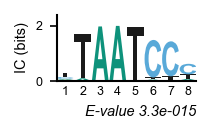

In [109]:
name = "Ehom_atacGain.STREME-1"

fig, axes = plt.subplots(figsize=(1.2,.8), nrows=2, dpi=150, #constrained_layout=True,
                         gridspec_kw=dict(height_ratios=[3,1], hspace=0.1))

pwm_ax = axes[0]
#pwm_ax.axis("off")
#pwm_ax.set_frame_on(False)
pwm = atac_meme_pwms[name].copy()
# get reverse complement
pwm = specseq_ewm_utils.get_motif_revcomp(pwm)
fig, pwm_ax, pwm_logo = specseq_plot_utils.make_pwm_logo(pwm, sequence_design=None, add_filler=False, figax=(fig, pwm_ax))
pwm_ax.set_ylim(bottom=0, top=2.4)
pwm_ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
#pwm_ax.xaxis.set_visible(False)
#pwm_ax.yaxis.set_visible(False)
#[s.set_visible(False) for s in pwm_ax.spines.values()]
# Hide the right and top spines
pwm_ax.spines[['right', 'top']].set_visible(False)
pwm_ax.spines[['left', 'bottom']].set_visible(True)
pwm_ax.set_ylabel("IC (bits)")

# add STREME stats
stats_text = atac_meme_stats[name]
stats_ax = axes[1]
stats_ax.axis("off")
stats_ax.text(1,.1, f"E-value {stats_text}", fontsize=mpl.rcParams["axes.titlesize"], style="italic", va="top", ha="right")

In [110]:
specseq_plot_utils.save_fig(fig, prefix=os.path.join(outbase_dir, "manuscript", "figure3_e80a_up_atac_pwm"), timestamp=False, tight_layout=False)

Text(1, 0.1, 'E-value 2.9e-005')

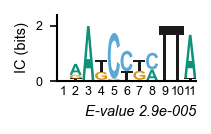

In [133]:
name = "Ehom_atacLost.STREME-1"

fig, axes = plt.subplots(figsize=(1.2,.8), nrows=2, dpi=150, #constrained_layout=True,
                         gridspec_kw=dict(height_ratios=[3,1], hspace=0.1))

pwm_ax = axes[0]
#pwm_ax.axis("off")
#pwm_ax.set_frame_on(False)
pwm = atac_meme_pwms[name].copy()
# get reverse complement
#pwm = specseq_ewm_utils.get_motif_revcomp(pwm)
# pad the pwm to match 11bp dimeric motif
pwm = pd.concat([pd.DataFrame(pd.Series({"A":0.25,"C":0.25,"G":0.25,"T":0.25})).T, pwm], axis=0)
pwm["pos"] = pwm.index+1
pwm = pwm.set_index("pos")
fig, pwm_ax, pwm_logo = specseq_plot_utils.make_pwm_logo(pwm, sequence_design=None, add_filler=False, figax=(fig, pwm_ax))
pwm_ax.set_ylim(bottom=0, top=2.4)
pwm_ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
#pwm_ax.xaxis.set_visible(False)
#pwm_ax.yaxis.set_visible(False)
#[s.set_visible(False) for s in pwm_ax.spines.values()]
# Hide the right and top spines
pwm_ax.spines[['right', 'top']].set_visible(False)
pwm_ax.spines[['left', 'bottom']].set_visible(True)
pwm_ax.set_ylabel("IC (bits)")

# add STREME stats
stats_text = atac_meme_stats[name]
stats_ax = axes[1]
stats_ax.axis("off")
stats_ax.text(1,.1, f"E-value {stats_text}", fontsize=mpl.rcParams["axes.titlesize"], style="italic", va="top", ha="right")

In [130]:
specseq_plot_utils.save_fig(fig, prefix=os.path.join(outbase_dir, "manuscript", "figure3_e80a_down_atac_pwm"), timestamp=False, tight_layout=False)

#### small heatmap showing E80A lost dimeric K50 motifs are made up of low-affinity half-sites

In [18]:
e80a_atac_fimo = pd.read_csv(os.path.join(atac_basedir, "e80a_atac_consensus_fimo.tsv"), sep="\t", header=0)[:-3].drop(columns=["motif_alt_id"])

In [19]:
# pull out motif matches to dimeric K50 motifs scanned using the E80A/A lost de novo found pwm
k50_dimer_fimo_table = e80a_atac_fimo.loc[lambda df:df["motif_id"]=="E80A_atacLost.MEME-19",:].copy()
# constraints on core motif nucleotides
k50_dimer_fimo_table["core"] = k50_dimer_fimo_table["matched_sequence"].apply(lambda x: x[1:3]+x[-3:-1]) 
k50_dimer_fimo_table["spacer"] = k50_dimer_fimo_table["matched_sequence"].apply(lambda x: x[4:7])
k50_dimer_fimo_table["spacer2"] = k50_dimer_fimo_table["matched_sequence"].apply(lambda x: x[3:8]) 
k50_dimer_fimo_table = k50_dimer_fimo_table.loc[lambda df: df["core"]=="AATT",:].copy().reset_index(drop=True)

k50_dimer_count_df = k50_dimer_fimo_table["matched_sequence"].to_frame("sequence").reset_index(drop=True)
compliment = {"A": "T", "C": "G", "G": "C", "T": "A", "N": "N"}
def reverse_rmatch(old_seq):
    rev_seq = old_seq[::-1]
    rev_comp = "".join([compliment[i] for i in rev_seq])
    return rev_comp
k50_dimer_count_df["halfsite1"] = k50_dimer_count_df["sequence"].apply(lambda x: x[:6]) 
k50_dimer_count_df["halfsite2"] = k50_dimer_count_df["sequence"].apply(lambda x: reverse_rmatch(x[-6:]))

column_name = "max.aff"

use_ewm_k50 = prtf_meme_ewms["CRX_Corbo"].iloc[range(1,7),:].copy().reset_index(drop=True)
# format ewm indexes
use_ewm_k50["pos"] = use_ewm_k50.index+1
use_ewm_k50 = use_ewm_k50.set_index("pos")
use_ewm_k50.index.name = ""

k50_dimer_count_df["halfsite.aff1"] = specseq_predict_occp.get_max_halfsite_aff(seq_ser=k50_dimer_count_df["halfsite1"], use_ewm=use_ewm_k50, mu=9)[column_name]
k50_dimer_count_df["halfsite.aff2"] = specseq_predict_occp.get_max_halfsite_aff(seq_ser=k50_dimer_count_df["halfsite2"], use_ewm=use_ewm_k50, mu=9)[column_name]

Text(0.5, 1.8, 'Predicted relative affinity (a.u.)\nWT CRX monomeric PWM')

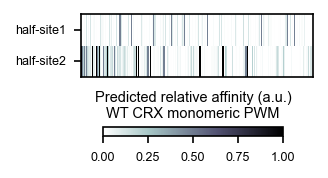

In [20]:
fig, ax_list = plt.subplots(figsize=(2,1.2), nrows=2, dpi=150)

data_to_plot = k50_dimer_count_df.set_index("sequence").iloc[:,range(2,4)].T

sns.heatmap(data=data_to_plot, vmin=0, vmax=1, cmap="bone_r", cbar=False, ax=ax_list[0])

for _, spine in ax_list[0].spines.items():
    spine.set_visible(True)

ax_list[0].set_yticks([.5,1.5], ["half-site1","half-site2"])
ax_list[0].set_xticks([])

ax_list[0].set_xlabel("")

ax_list[1].axis("off")
# add color bar on the right
cbar_ax = plt.axes([.2, .2, .6, .05])
cbar_ax.set_frame_on(True)
norm = mpl.colors.Normalize(vmin=0, vmax=1)
colorbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="bone_r"),
        cax=cbar_ax, orientation='horizontal')
cbar_ax.text(.5,1.8, "Predicted relative affinity (a.u.)\nWT CRX monomeric PWM",
              rotation=0, fontsize=mpl.rcParams['axes.titlesize'], va="bottom", ha="center")

In [65]:
specseq_plot_utils.save_fig(fig, prefix=os.path.join(outbase_dir, "supplementary", "supp3a_e80a_down_halfsite_affinity"), timestamp=False, tight_layout=False)

#### Developmental dynamics lineplots of E80A differential ATAC peaks

In [13]:
# developmental atac pattern at E80A differential peaks
# convert aldiri atac count matrix to rowz
### row z-score transform the scATAC matrix
tmp = e80a_atac_aldiri.iloc[:, range(7,13)].T.copy().astype(np.float64)
# sklearn https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
scaler = StandardScaler()
# fit the data
scaler.fit(tmp)
# Perform standardization by centering and scaling.
tmp_rowz_array = scaler.transform(tmp)

# convert the rowz array to dataframe
tmp_rowz = pd.DataFrame(tmp_rowz_array).T
tmp_rowz.columns = tmp.index
tmp_rowz.index = tmp.columns
tmp_rowz["mean"] = scaler.mean_
tmp_rowz["variance"] = scaler.var_

# calculate the coefficient of variation cov = std/mean
tmp_rowz["cov"] = scipy.stats.variation(tmp, axis=0, nan_policy='propagate', ddof=1, keepdims=False)
    
# attach the annotation
e80a_aldiri_normalized_rowz = pd.concat([e80a_atac_aldiri.iloc[:, range(5)], tmp_rowz], axis=1)


In [14]:
# attach e80a atac annotation
e80a_atac_aldiri_data = e80a_aldiri_normalized_rowz.rename(columns={"seqnames":"e80a.seqnames","start":"e80a.start","end":"e80a.end"}).\
                        merge(e80a_atac_intersect_df[["e80a.peak.id","e80a.seqnames","e80a.start","e80a.end","aa_atac_cluster"]], how="right")
                                                    

e80a_atac_aldiri_data.replace([np.inf, -np.inf], np.nan, inplace=True)
e80a_atac_aldiri_data = e80a_atac_aldiri_data.dropna()

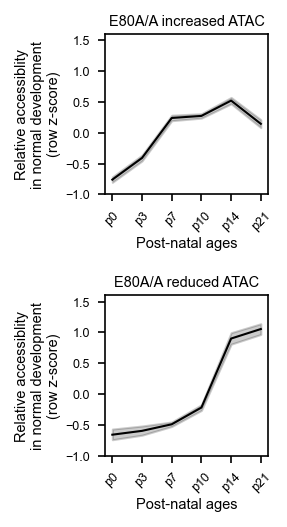

In [15]:
fig, ax_list = plt.subplots(ncols=1, nrows=2, figsize=(1.8,3.4), dpi=150, constrained_layout=True,
                           gridspec_kw=dict(height_ratios=[1,1], hspace=0.1))

fig, ax_list = rnaseq_plot_utils.dev_line_by_rnaGp(data=e80a_atac_aldiri_data, group_col="aa_atac_cluster", id_col="e80a.peak.id", ages=[f"wt_{age}_atac" for age in ["p0","p3","p7","p10","p14","p21"]],
                                                        morder=["aa.atac.gain","aa.atac.lost"], 
                                                        mpal={"aa.atac.lost":"black", "aa.atac.notDA":"black", "aa.atac.gain":"black"},
                                                        xlabel="Post-natal ages", ylabel="Relative accessiblity\nin normal development\n(row z-score)", 
                                                        uniform_y=True, figax=(fig, ax_list))

plot_ages=["p0","p3","p7","p10","p14","p21"]
for title, ax in zip(["increased", "reduced"],ax_list):
    ax.set_ylim(-1,1.6) 
    ax.set_title(f"E80A/A {title} ATAC") 
    ax.set_xticks(range(len(plot_ages)),plot_ages, rotation=45)

In [13]:
specseq_plot_utils.save_fig(fig, prefix=os.path.join(outbase_dir, "manuscript", "figure3_e80a_aldiri_atac"), timestamp=False, tight_layout=False)

#### Association of HD motif type(s) and CRX regulated genes

In [16]:
# CRX-dependent activated gene list with their grouping annotation, taken directly from previous publication Zhneg 2023
grouped_genelist = pd.read_csv(os.path.join(rna_basedir, "grouped_crx_dependent_genelist.tsv"), sep="\t", header=0)
group1_genes = grouped_genelist.loc[lambda df: df["Group"]=="Group1","Gene"].squeeze()
group2_genes = grouped_genelist.loc[lambda df: df["Group"]=="Group2","Gene"].squeeze()

In [17]:
len(set(k50_gene_annot["gene"].unique()).intersection(grouped_genelist["Gene"]))

142

In [18]:
# save the CRX dependent activated gene subset motif annotation in a separate matrix
tmp = k50_gene_annot.loc[lambda df: df["gene"].isin(grouped_genelist["Gene"]),["peak.id","seqnames", "start", "end", "gene","k50_mono","k50_di","q50_mono","q50_di","k50_group","q50_group"]].copy()
#tmp.to_csv(os.path.join(rna_basedir, "crxdags_cre_hdmotif_annotation.tsv"), sep="\t", index=False, header=True)
del(tmp)

In [25]:
gene_motif_count = unique_gene_motif.loc[lambda df: df["gene"].isin(grouped_genelist["Gene"]),"k50_group"].value_counts().to_frame("count")
gene_motif_count["fraction"] = gene_motif_count["count"].div(gene_motif_count["count"].sum())
gene_motif_count = gene_motif_count.reindex(range(4))

display(gene_motif_count)

,count,fraction
0,7,0.049296
1,41,0.288732
2,7,0.049296
3,87,0.612676


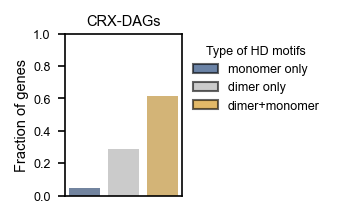

In [26]:
# percentage of genes with M, D or M+D HD motifs in their CREs
#triple_colorlist = ["dimgray","darkgray","lightgray"]
triple_colorlist = ["#08306B", "#A9A9A9", "#CF8B03"]

set_alpha=0.6

# make a grouped barchart
fig, ax = plt.subplots(figsize=(1,1.4), dpi=150)

data_to_plot = gene_motif_count.copy().reset_index(drop=False)
ax = sns.barplot(data=data_to_plot.loc[range(1,4),:], x="count", y="fraction",
                    alpha=set_alpha,
                    palette=triple_colorlist,
                    ax=ax
                    )
ax.set_ylim(0,1)
ax.set_xticks([])
ax.set(title="CRX-DAGs",
       xlabel="",
       ylabel="Fraction of genes")

# add legend 
legend_elements = [Rectangle((0,0), .1, .2,
                            facecolor=triple_colorlist[0], edgecolor="k", alpha=set_alpha,
                                label="monomer only"),
                    Rectangle((0,0), .1, .2, 
                            facecolor=triple_colorlist[1], edgecolor="k", alpha=set_alpha,
                                label="dimer only"),
                   Rectangle((0,0), .1, .2,
                            facecolor=triple_colorlist[2], edgecolor="k", alpha=set_alpha,
                                label="dimer+monomer"),
                        ]

leg = ax.legend(handles=legend_elements, 
                    title="Type of HD motifs",
                    loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
        
leg._legend_box.align = "center"

#fig.tight_layout()

In [81]:
specseq_plot_utils.save_fig(fig, prefix=os.path.join(outbase_dir, "manuscript", "figure4b_fraction_gene_HDmotiftypes"), timestamp=False, tight_layout=False)

#### Correlation with differential gene expression at P10 and P21

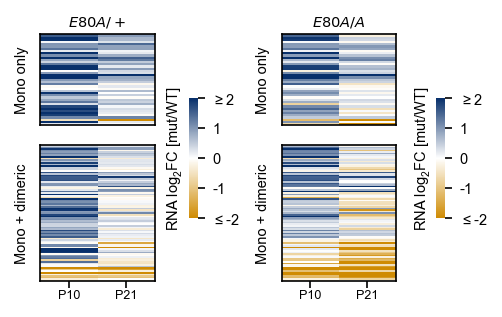

In [27]:
# set up the figure
fig, ax_list = plt.subplots(ncols=4, nrows=2, figsize=(3,2), dpi=150, constrained_layout=True, 
                            gridspec_kw=dict(height_ratios=[1,1.5],width_ratios=[1,.3,1,.2], wspace=0.3))

pick_columns = ["p10.ehet.lfc","p10.ehom.lfc","p21.ehet.lfc","p21.ehom.lfc"]
for j,motif in enumerate([1,3]):
    # clustering
    data = unique_gene_motif.loc[lambda df: df["gene"].isin(unique_gene_motif.loc[lambda df: df["k50_group"]==motif,"gene"]),:].copy()
    data = data.loc[lambda df: df["gene"].isin(grouped_genelist["Gene"].unique()),:].dropna().reset_index(drop=True)
    # hierarchical clustering of the lfc expression matrix 
    crxdag_motif_cg = chipseq_plot_utils.chip_intensity_heatmap(data=data.loc[:,["p10.ehet.lfc","p10.ehom.lfc","p10.rhom.lfc"]].copy(),  
                                                                hm_title=None, hm_xlabel=None, cb_title=None, cmap=div_heat_colors, 
                                                                paramdict=dict(
                                                                                z_score=0, # z normalized by row
                                                                                metric="euclidean", # plot with euclidean distance
                                                                                method="complete", # linkage method to use for calculating clusters
                                                                ))
    crxdag_motif_cg.ax_row_dendrogram.set_visible(True)
    new_order = crxdag_motif_cg.dendrogram_row.reordered_ind
    plt.close()

    # reorder the lfc dataframe based on clustering
    reordered_data = data.iloc[new_order,:].reset_index(drop=True)
    # reverse the order so that up-regulated genes are on top
    reordered_data = reordered_data.loc[::-1].reset_index(drop=True)

    # simply order by rank
    #reordered_data = data.sort_values(by="p21.ehom.lfc", ascending=False)

    for i,genotype in enumerate(["ehet","ehom"]):
        ax = ax_list[j,2*i]
        data_to_plot = reordered_data.loc[:,[f"p10.{genotype}.lfc",f"p21.{genotype}.lfc"]].copy()
        ax = sns.heatmap(data=data_to_plot, ax=ax, cmap=div_heat_colors, vmin=-2, vmax=2, cbar=False)
        
        # frame the heatmap
        for _, spine in ax.spines.items():
            spine.set_visible(True)

        if j==0:
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(f"$\it {pretty_names[genotype]}$")
            ax.set_ylabel(f"Mono only") #\nn={len(reordered_data.index)}
        else:
            ax.set_xticks([0.5,1.5],["P10","P21"],rotation=0,ha="center",va="center")
            ax.set_yticks([])
            ax.set_ylabel(f"Mono + dimeric") #\nn={len(reordered_data.index)}

        # annotate the couple genes
        annot_genes = []
        annot_genes_y = []
        for i,gene in enumerate(reordered_data["gene"]):
            if gene in ["Rcvrn","Pla2r1","Esrrb","Rho","Gnat1","Guca1a","Arr3","Pde6g"]:
                #print(gene)
                annot_genes.append(gene)
                annot_genes_y.append(i)
        #ax.yaxis.tick_right()
        #ax.set_yticks(annot_genes_y, annot_genes,rotation=0, ha="left")
        #ax.yaxis.set_label_position("right")
        
# add color bar separately
ax_list[0,3].axis("off")
ax_list[1,3].axis("off")
ax_list[0,1].axis("off")
ax_list[1,1].axis("off")
for x_pos in [0.95,0.40]:
    cbar_ax = plt.axes([x_pos, .3, 0.02, 0.4])
    cbar_ax.set_frame_on(False)
    norm = mpl.colors.Normalize(vmin=-2, vmax=2)
    colorbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=div_heat_colors), ticks=[-2,-1,0,1,2],
            cax=cbar_ax, orientation='vertical')
    ticks = cbar_ax.get_yticks()
    ticks = [f"{i:.0f}" for i in ticks]
    ticks[-1] = r"$\geq$" + ticks[-1]
    ticks[0] = r"$\leq$" + ticks[0]
    cbar_ax.set_yticklabels(ticks)
    cbar_ax.tick_params(labelsize=7, rotation=0)
    cbar_ax.text(-.4,0, f"RNA $log_{2}$FC [mut/WT]", rotation=90, fontsize=mpl.rcParams['axes.titlesize'], va="center", ha="right")

In [13]:
specseq_plot_utils.save_fig(fig, prefix=os.path.join(outbase_dir, "manuscript", f"figure4e_e80aRNA_HDtype_geneExp"), timestamp=False, tight_layout=False)

#### CRX expression during normal post-natal retinal development - Bulk RNA-seq and qRT-PCR

In [28]:
# prepare the qRT-PCR data
qPCR_df = pd.read_csv(os.path.join(rna_basedir, "hdmuts_qPCR_deltaDq.tsv"), sep="\t")
melted_qPCR_df = pd.melt(qPCR_df, id_vars=["genotype", "gene", "rep"], value_vars=["p0","p3","p5","p7", "p10","p14","p21"], var_name="age", value_name="fc")
avg_qPCR_df = melted_qPCR_df.groupby(["genotype","gene","age"])["fc"].mean().unstack()

# extract only the wt sample means and reorder columns by age
wt_qPCR_df = avg_qPCR_df.loc["wt"].copy().loc[:,["p0","p3","p5","p7","p10","p14","p21"]]
# extract the Crx qPCR datapoints and normalized to p3
crx_qPCR_df = qPCR_df.loc[lambda df: (df["gene"]=="Crx")&(df["genotype"]=="wt"),["p0","p3","p5","p7","p10","p14","p21"]]
crx_avg_qPCR_df = wt_qPCR_df.loc["Crx",:].copy()
crx_qPCR_df = crx_qPCR_df.applymap(lambda x: crx_avg_qPCR_df["p3"]-x)
# convert delta Cq to fc
#crx_qPCR_df = crx_qPCR_df.applymap(lambda x: np.power(2,x))

# convert to long-form dataframe
melted_crx_qPCR_df = pd.melt(crx_qPCR_df, value_vars=["p0","p3","p5","p7", "p10","p14","p21"], var_name="age", value_name="fc").dropna()

In [29]:
# prepare the Aldiri RNA-seq data
crx_aldiri_counts = aldiri_rna_normalized_counts.loc[lambda df: df["gene"]=="Crx",["p0","p3","p7","p10","p14","p21"]]
crx_aldiri_counts = crx_aldiri_counts/crx_aldiri_counts.iloc[0,1]
# convert fc to log2 fc
crx_aldiri_counts = crx_aldiri_counts.applymap(np.log2)

Text(0, 0.5, 'Aldiri RNA-seq')

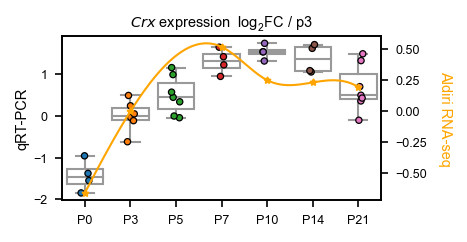

In [33]:
fig, ax= plt.subplots(figsize=(3,1.5), dpi=150, constrained_layout=True)
# qRT-PCR strip and box plots
ax = sns.stripplot(x="age", y="fc", data=melted_crx_qPCR_df, edgecolor="black", facecolor="none", 
                   dodge=True, linewidth=.6, marker="o", size=3, jitter=.1, ax=ax)
ax = sns.boxplot(x="age", y="fc", data=melted_crx_qPCR_df, color="white", linewidth=1, 
                 saturation=1, dodge=True, whis=np.inf, ax=ax)

# decorations
ax.set(xlabel="", ylabel="qRT-PCR", title=f"$\it Crx$ expression  $log_{2}FC$ / p3")
ax.set_xticklabels([str.upper(x) for x in ["p0","p3","p5","p7", "p10","p14","p21"]])

# draw Aldiri RNA-seq data on the second y-axis
ax2 = ax.twinx()
#create data
x = np.array([0,1,3,4,5,6]) # aldiri data does not have p5, skipping index 2
y = np.array(list(crx_aldiri_counts.iloc[0,:]))
    
# make scatter plot
ax2.scatter(x, y, c="orange", marker="*", s=8)
   
# define x as 200 equally spaced values between the min and max of original x 
xnew = np.linspace(x.min(), x.max(), 200) 
# define spline with degree k
spl = make_interp_spline(x, y, k=3)
y_smooth = spl(xnew)

# create smooth line chart 
ax2.plot(xnew, y_smooth, c="orange", linewidth=1, label=None)
ax2.set_ylabel("Aldiri RNA-seq", color="orange", rotation=270, labelpad=12)

In [252]:
specseq_plot_utils.save_fig(fig, prefix=os.path.join(outbase_dir, "supplementary", "supp3a_developmental_crx_expression"), timestamp=False, tight_layout=False)

#### Developmental expression dynamics of CRX-DAGs associated with different type of HD motifs

In [34]:
# Row Z transform the Aldiri developmental time-series RNAseq data
tmp = aldiri_rna_normalized_counts.iloc[:, range(4,10)].T.copy().astype(np.float64)
# sklearn https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
scaler = StandardScaler()
# fit the data
scaler.fit(tmp)
# Perform standardization by centering and scaling.
tmp_rowz_array = scaler.transform(tmp)

# convert the rowz array to dataframe
tmp_rowz = pd.DataFrame(tmp_rowz_array).T
tmp_rowz.columns = tmp.index
tmp_rowz.index = tmp.columns
tmp_rowz["mean"] = scaler.mean_
tmp_rowz["variance"] = scaler.var_

# calculate the coefficient of variation cov = std/mean
tmp_rowz["cov"] = scipy.stats.variation(tmp, axis=0, nan_policy='propagate', ddof=1, keepdims=False)
    
# attach the annotation
aldiri_rna_normalized_rowz = pd.concat([aldiri_rna_normalized_counts.iloc[:, range(2)], tmp_rowz], axis=1)

In [35]:
crx_dependent_gene_aldiri = unique_gene_motif.loc[lambda df: df["gene"].isin(grouped_genelist["Gene"]),["gene","k50_group"]].copy().merge(aldiri_rna_normalized_counts, on="gene")
tmp_aldiri = crx_dependent_gene_aldiri[["p0","p3","p7","p10","p14","p21"]].div(crx_dependent_gene_aldiri["p3"], axis=0)
crx_dependent_gene_aldiri = pd.concat([crx_dependent_gene_aldiri[["gene","k50_group"]],tmp_aldiri], axis=1)

del(tmp_aldiri)

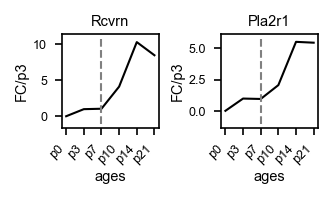

In [36]:
fig, ax_list = plt.subplots(ncols=2, nrows=1, figsize=(2.1,1.2), dpi=150,
                            constrained_layout=True)

for ax,gene in zip(ax_list, ["Rcvrn","Pla2r1"]):
    data_to_plot = crx_dependent_gene_aldiri.loc[lambda df: df["gene"]==gene,["p0","p3","p7","p10","p14","p21"]]
    data_to_plot.index = [gene]
    data_to_plot = data_to_plot.T
    data_to_plot = data_to_plot.reset_index(drop=True).reset_index(drop=False).rename(columns={"index":"age"})
    ax =  sns.lineplot(data = data_to_plot,
                       x="age", 
                       y=gene, 
                       ax=ax, color="k")
    ax.set(xlabel="ages", ylabel="FC/p3", title=gene)
    ax.set_xticks(range(6), ["p0","p3","p7","p10","p14","p21"], rotation=45, ha="right", va="top")

    ax.vlines(x=2,ymin=-1,ymax=ax.get_ylim()[1], color="grey", linestyles="--")
    #ax.set_ylim(-1,15)

specseq_plot_utils.save_fig(fig, prefix=os.path.join(outbase_dir, "supplementary", "supp4_Mgenes_aldiriLinePlots"), timestamp=False, tight_layout=False)


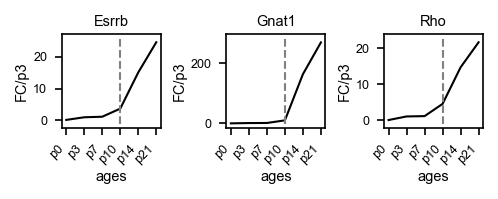

In [39]:
fig, ax_list = plt.subplots(ncols=3, nrows=1, figsize=(3.2,1.2), dpi=150,
                            constrained_layout=True)

for ax,gene in zip(ax_list, ["Esrrb","Gnat1","Rho"]):
    data_to_plot = crx_dependent_gene_aldiri.drop_duplicates(subset="gene").loc[lambda df: df["gene"]==gene,["p0","p3","p7","p10","p14","p21"]]
    data_to_plot.index = [gene]
    data_to_plot = data_to_plot.T
    data_to_plot = data_to_plot.reset_index(drop=True).reset_index(drop=False).rename(columns={"index":"age"})
    ax =  sns.lineplot(data = data_to_plot,
                       x="age", 
                       y=gene, 
                       ax=ax, color="k")
    ax.set(xlabel="ages", ylabel="FC/p3", title=gene)
    ax.set_xticks(range(6), ["p0","p3","p7","p10","p14","p21"], rotation=45, ha="right", va="top")
    ax.vlines(x=3,ymin=-1,ymax=ax.get_ylim()[1], color="grey", linestyles="--")
    
    #ax.set_ylim(-1,30)

specseq_plot_utils.save_fig(fig, prefix=os.path.join(outbase_dir, "supplementary", "supp4_M+Dgenes_aldiriLinePlots"), timestamp=False, tight_layout=False)  

Text(0.5, 1.0, 'Genes regulated by\nmono + di CREs')

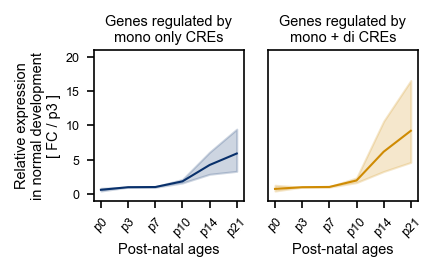

In [40]:
fig, ax_list = plt.subplots(ncols=2, nrows=1, figsize=(2.8,1.7), dpi=150,
                            constrained_layout=True)

fig, ax_list = rnaseq_plot_utils.dev_line_by_rnaGp(data=crx_dependent_gene_aldiri, group_col="k50_group", id_col="gene", ages=["p0","p3","p7","p10","p14","p21"],
                                                        morder=[1,3], 
                                                        mpal={1:"#08306B", 3:"#CF8B03"},
                                                        xlabel="Post-natal ages", ylabel="Relative expression\nin normal development\n[ FC / p3 ]", 
                                                        uniform_y=True, figax=(fig, ax_list))

plot_ages=["p0","p3","p7","p10","p14","p21"]
for ax in ax_list:
    ax.set_ylim(-1,21) 
    ax.set_xticks(range(len(plot_ages)),plot_ages, rotation=45)

ax_list[0].set_title("Genes regulated by\nmono only CREs")
ax_list[1].set_title("Genes regulated by\nmono + di CREs")

In [18]:
specseq_plot_utils.save_fig(fig, prefix=os.path.join(outbase_dir, "supplementary", "supp3b_genesByHDMotif_devExp"), timestamp=False, tight_layout=False)

#### Separate rod vs cone enriched genes, and plot fraction associated with HD motifs

In [41]:
# gather the number of group1/2 genes asscoiated with M, D, M+D type CREs, calculate fraction
group1_gene_motif_count = pd.DataFrame(np.array([3,45,4,86]), index=range(4), columns=["count"])
group1_gene_motif_count["fraction"] = group1_gene_motif_count["count"]/group1_gene_motif_count["count"].sum()
group2_gene_motif_count = pd.DataFrame(np.array([2,3,4,39]), index=range(4), columns=["count"]) 
group2_gene_motif_count["fraction"] = group2_gene_motif_count["count"]/group2_gene_motif_count["count"].sum()

group1_gene_motif_count["group"] = "group1"
group2_gene_motif_count["group"] = "group2"

data_to_plot = pd.concat([group1_gene_motif_count, group2_gene_motif_count], ignore_index=True)
display(data_to_plot)

,count,fraction,group
0,3,0.021739,group1
1,45,0.326087,group1
2,4,0.028986,group1
3,86,0.623188,group1
4,2,0.041667,group2
5,3,0.062500,group2
6,4,0.083333,group2
7,39,0.812500,group2


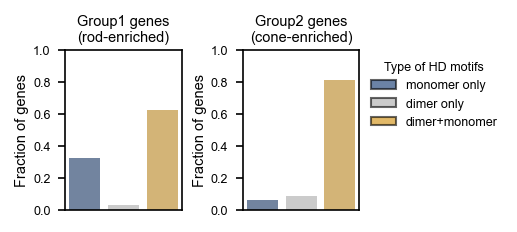

In [42]:
#triple_colorlist = ["dimgray","darkgray","lightgray"]
triple_colorlist = ["#08306B", "#A9A9A9", "#CF8B03"]

# make a grouped barchart
fig, axes = plt.subplots(figsize=(3.4,1.5), ncols=2, dpi=150)

for ax, data_to_plot in zip(axes, [group1_gene_motif_count, group2_gene_motif_count]):
    data_to_plot = data_to_plot.copy().reset_index(drop=False)
    ax = sns.barplot(data=data_to_plot.loc[range(1,4),:], x="index", y="fraction",
                     alpha=set_alpha,
                     palette=triple_colorlist,
                     ax=ax
                    )
    ax.set_xticks([])
    ax.set(title="", xlabel="", ylabel="Fraction of genes")
    
    ax.set_ylim(0,1)

axes[0].set_title("Group1 genes\n(rod-enriched)")
axes[1].set_title("Group2 genes\n(cone-enriched)")

# add legend 
legend_elements = [Rectangle((0,0), .1, .2,
                            facecolor=triple_colorlist[0], edgecolor="k", alpha=set_alpha,
                                label="monomer only"),
                    Rectangle((0,0), .1, .2, 
                            facecolor=triple_colorlist[1], edgecolor="k", alpha=set_alpha,
                                label="dimer only"),
                   Rectangle((0,0), .1, .2,
                            facecolor=triple_colorlist[2], edgecolor="k", alpha=set_alpha,
                                label="dimer+monomer"),
                        ]

leg = axes[1].legend(handles=legend_elements, 
                    title="Type of HD motifs",
                    loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
        
leg._legend_box.align = "center"

fig.tight_layout()

In [308]:
specseq_plot_utils.save_fig(fig, prefix=os.path.join(outbase_dir, "supplementary", "supp3d_fraction_gene_byCellType_HDmotiftypes"), timestamp=False, tight_layout=False)

#### Highlight the subset of genes that are strongly under-expressed, reduced accessiblity, and lost E80A binding

In [43]:
genes_to_plot = k50_gene_annot.loc[:,["gene","peak.id","k50_mono","k50_di","q50_mono","q50_di"]].\
                        merge(e80a_atac_intersect_df[["chip.peak.id","chip.e80a.lfc","atac.aa.lfc","atac.at.lfc"]].\
                        rename(columns={"chip.peak.id":"peak.id"}), on="peak.id")
# annotate whether it is CRX dependent
genes_to_plot["depGene"] = np.nan
genes_to_plot[["depGene"]] = genes_to_plot[["depGene"]].mask(genes_to_plot["gene"].isin(grouped_genelist["Gene"]), "Y", inplace=False)
genes_to_plot[["depGene"]] = genes_to_plot[["depGene"]].fillna("N")

In [45]:
subset_genes_to_plot = genes_to_plot.loc[lambda df: df["gene"].isin(list(unique_gene_motif.loc[lambda df: (df["k50_group"].isin([1,3]))&(df["p21.ehet.lfc"]<0),"gene"])),:].copy()
subset_genes_to_plot = subset_genes_to_plot.loc[lambda df: df["gene"].isin(list(group1_genes)+list(group2_genes)),:]#.drop_duplicates(subset="gene")
subset_genes_to_plot = subset_genes_to_plot.merge(unique_gene_motif[["gene","k50_group","q50_group","p21.ehom.lfc","p21.ehet.lfc"]])
subset_genes_to_plot = subset_genes_to_plot.loc[lambda df: (df["chip.e80a.lfc"]<-.1)&(df["atac.aa.lfc"]<-.2),:].sort_values(by="atac.aa.lfc",ascending=True)
subset_genes_to_plot = subset_genes_to_plot.sort_values(by="p21.ehet.lfc",ascending=True).reset_index(drop=True)

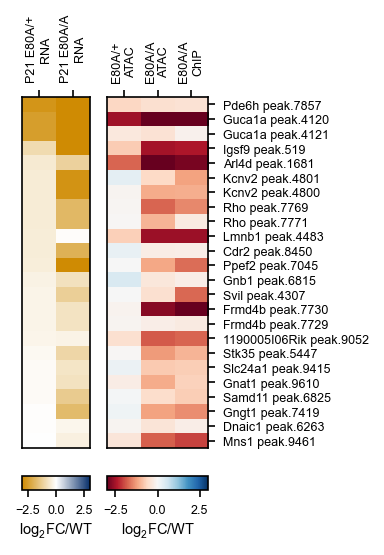

In [46]:
fig, ax_list = plt.subplots(ncols=2, figsize=(1.6,3.4), dpi=150,
                            constrained_layout=False, gridspec_kw=dict(width_ratios=[2,3], wspace=.2)) #vertical

ax=ax_list[1]
heatmap = ax.imshow(subset_genes_to_plot[["atac.at.lfc","atac.aa.lfc","chip.e80a.lfc"]].astype(float), aspect="auto", vmin=-3, vmax=3, cmap="RdBu")

ax.xaxis.tick_top() 
ax.set_xticks(np.arange(3))
ax.set_xticklabels(["E80A/+\nATAC","E80A/A\nATAC","E80A/A\nChIP"], rotation=90, ha="center", va="bottom")
ax.set_xlabel("")
ax.set_ylabel("")
ax.yaxis.tick_right()
ax.set_yticks(np.arange(len(subset_genes_to_plot.index)))
ax.set_yticklabels(subset_genes_to_plot["gene"]+" "+subset_genes_to_plot["peak.id"])

# Add a colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="4%", pad="8%")
colorbar = fig.colorbar(heatmap, cax=cax, orientation="horizontal", label=r"$log_{2}$FC/WT")

ax = ax_list[0]
heatmap = ax.imshow(subset_genes_to_plot[["p21.ehet.lfc","p21.ehom.lfc"]].astype(float), aspect="auto", vmin=-3, vmax=3, cmap=div_heat_colors)
ax.set_xlabel("")
ax.xaxis.tick_top() 
ax.set_xticks(np.arange(2))
ax.set_xticklabels(["P21 E80A/+\nRNA","P21 E80A/A\nRNA"], rotation=90, ha="center", va="bottom")
ax.set_yticks([])
ax.set_ylabel("")

# Add a colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="4%", pad="8%")
colorbar = fig.colorbar(heatmap, cax=cax, orientation="horizontal", label=r"$log_{2}$FC/WT")

In [361]:
specseq_plot_utils.save_fig(fig, prefix=os.path.join(outbase_dir, "supplementary", "supp3c_e80aDownGenes_RAC"), timestamp=False, tight_layout=False)

### IV. K88N vs WT ATAC seq

In [363]:
# display percentage of differential ATAC peaks
k88n_atac_intersect_df["nn_atac_cluster"].value_counts()/len(k88n_atac_intersect_df)

nn_atac_cluster
nn.atac.notDA    0.917994
nn.atac.gain     0.059493
nn.atac.lost     0.022513
Name: count, dtype: float64

#### ATACseq intensity heatmap - re-arrangement of deeptools heatmaps

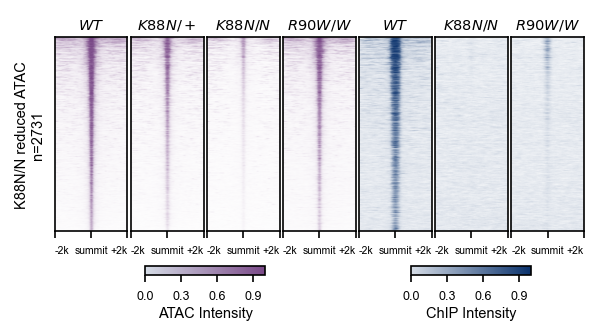

In [22]:
## DEEPTOOLS HEATMAP with MEME MOTIFS
nn_atac_heatmap_dir = os.path.join(outbase_dir, "heatmaps", "nn_images", "600ppi")

# set up the figure
fig = plt.figure(figsize=(4,2), dpi=150) #constrained_layout=True, 
gs = fig.add_gridspec(nrows=3, ncols=8, width_ratios=[.1,1,1,1,1,1,1,1], height_ratios=[.1,1,.1])
gs.update(left=.05,right=.95,top=.9,bottom=.1,wspace=0.05,hspace=0.05) #padding for each grid space

peak_order = ["lost"]
peak_label = ["reduced"]
peak_num = [2731]
labels = [ "wt_atac", "khet_atac", "khom_atac", "rhom_atac", "wt_chip", "k88n_chip", "r90w_chip"]
for i,peak, in enumerate(peak_order):
    # first add the cluster label
    text_ax = fig.add_subplot(gs[i+1, 0])
    text_ax.set_frame_on(False)
    text_ax.set_axis_off()
    text_ax.text(-.8, .5, f"K88N/N {peak_label[i]} ATAC\nn={str(peak_num[i])}\n", rotation=90, 
                 fontsize=mpl.rcParams["axes.labelsize"], va='center', ha='center')
    for j in range(7):
        ax = fig.add_subplot(gs[i+1, j+1])
        ax.set_frame_on(True)
        # add genotype label
        if i== 0:
            genotype = labels[j].split("_")[0]
            ax.set_title(f"$\it {pretty_names[genotype]}$")
        # get the width and height of axes box
        bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        width, height = bbox.width, bbox.height
        width *= fig.dpi
        height *= fig.dpi
        # read the heatmap image and resize
        img = mpimg.imread(os.path.join(nn_atac_heatmap_dir, f"{labels[j]}_nn_{peak_order[i]}.png"))
        # resize image
        #img = img.resize((int(width), int(height)))
        ax.imshow(img, aspect='auto', extent=(0,1,0,1), origin='upper', transform=ax.transAxes)
        if i < 0: # remove axis and frame if not the bottom row of heatmap
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
        else: # add the dist to submit labels
            ax.yaxis.set_visible(False) # hide y axis
            ax.spines.bottom.set_visible(True)
            ax.xaxis.set_ticks_position('bottom')
            ax.set_xticks([0,int(width)/2,int(width)])
            ax.set_xticklabels(["-2k","summit","+2k"], fontsize=5)
            # align the labels at two ends
            ticklabels = ax.get_xticklabels()
            # set the alignment for outer ticklabels
            ticklabels[0].set_ha("left")
            ticklabels[-1].set_ha("right")

# add experiment labels
atac_text_ax = fig.add_subplot(gs[0,1:5])
#atac_text_ax.text(.5, 2.5, "ATACseq", fontsize=mpl.rcParams["axes.titlesize"], ha="center", va="bottom")
atac_text_ax.axis('off')
#atac_text_ax.axhline(y=2.5, xmin=0, xmax=1, linewidth=1.5, color="k")

chip_text_ax = fig.add_subplot(gs[0,5:8])
#chip_text_ax.text(.5, 2.5, "CRX ChIPseq", fontsize=mpl.rcParams["axes.titlesize"], ha="center", va="bottom")
chip_text_ax.axis('off')
#chip_text_ax.axhline(y=2.5, xmin=0, xmax=1, linewidth=1.5, color="k")


# add a dummy color bar to the bottom of the lower right axes
# get the axes position of the heatmap title and center-align color bar to it
atac_cbar_pos = atac_text_ax.get_position()
atac_cbar_width = 0.2
atac_cbar_ax = plt.axes([(atac_cbar_pos.x0+atac_cbar_pos.x1-atac_cbar_width)/2, 0.03, atac_cbar_width, 0.03])
atac_cbar_ax.set_frame_on(True)
atac_norm = mpl.colors.Normalize(vmin=0, vmax=1.0)
atac_colorbar = fig.colorbar(mpl.cm.ScalarMappable(norm=atac_norm, cmap=atac_heat_colors), ticks=[0.0,0.3,0.6,0.9],
             cax=atac_cbar_ax, orientation='horizontal', label='ATAC Intensity')

chip_cbar_pos = chip_text_ax.get_position()
chip_cbar_width = 0.2
chip_cbar_ax = plt.axes([(chip_cbar_pos.x0+chip_cbar_pos.x1-chip_cbar_width)/2, 0.03, chip_cbar_width, 0.03])
chip_cbar_ax.set_frame_on(True)
chip_norm = mpl.colors.Normalize(vmin=0, vmax=1.0)
chip_colorbar = fig.colorbar(mpl.cm.ScalarMappable(norm=chip_norm, cmap=chip_heat_colors), ticks=[0.0,0.3,0.6,0.9],
             cax=chip_cbar_ax, orientation='horizontal', label='ChIP Intensity')


plt.show()

In [23]:
specseq_plot_utils.save_fig(fig, prefix=os.path.join(outbase_dir, "manuscript", "figure6_k88n_lost_atac_deeptools"), timestamp=False, tight_layout=False)

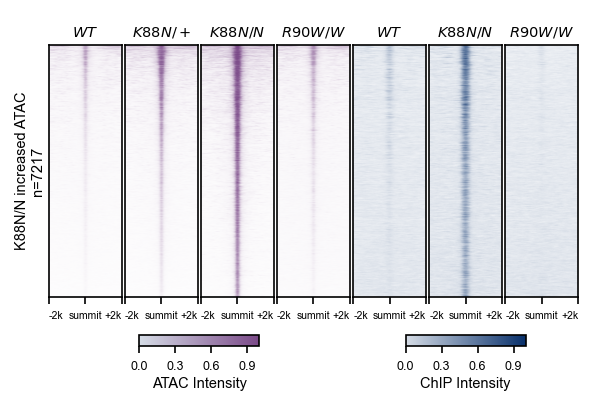

In [24]:
## DEEPTOOLS HEATMAP with MEME MOTIFS
nn_atac_heatmap_dir = os.path.join(outbase_dir, "heatmaps", "nn_images", "600ppi")

# set up the figure
fig = plt.figure(figsize=(4,2.6), dpi=150) #constrained_layout=True, 
gs = fig.add_gridspec(nrows=3, ncols=8, width_ratios=[.1,1,1,1,1,1,1,1], height_ratios=[.1,1,.1])
gs.update(left=.05,right=.95,top=.9,bottom=.1,wspace=0.05,hspace=0.05) #padding for each grid space

peak_order = ["gain"]
peak_label = ["increased"]
peak_num = [7217]
labels = [ "wt_atac", "khet_atac", "khom_atac", "rhom_atac", "wt_chip", "k88n_chip", "r90w_chip"]
for i,peak, in enumerate(peak_order):
    # first add the cluster label
    text_ax = fig.add_subplot(gs[i+1, 0])
    text_ax.set_frame_on(False)
    text_ax.set_axis_off()
    text_ax.text(0, .5, f"K88N/N {peak_label[i]} ATAC\nn={str(peak_num[i])}\n", rotation=90, 
                 fontsize=mpl.rcParams["axes.labelsize"], va='center', ha='center')
    for j in range(7):
        ax = fig.add_subplot(gs[i+1, j+1])
        ax.set_frame_on(True)
        # add genotype label
        if i== 0:
            genotype = labels[j].split("_")[0]
            ax.set_title(f"$\it {pretty_names[genotype]}$")
        # get the width and height of axes box
        bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        width, height = bbox.width, bbox.height
        width *= fig.dpi
        height *= fig.dpi
        # read the heatmap image and resize
        img = mpimg.imread(os.path.join(nn_atac_heatmap_dir, f"{labels[j]}_nn_{peak_order[i]}.png"))
        # resize image
        #img = img.resize((int(width), int(height)))
        ax.imshow(img, aspect='auto', extent=(0,1,0,1), origin='upper', transform=ax.transAxes)
        if i < 0: # remove axis and frame if not the bottom row of heatmap
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
        else: # add the dist to submit labels
            ax.yaxis.set_visible(False) # hide y axis
            ax.spines.bottom.set_visible(True)
            ax.xaxis.set_ticks_position('bottom')
            ax.set_xticks([0,int(width)/2,int(width)])
            ax.set_xticklabels(["-2k","summit","+2k"], fontsize=5)
            # align the labels at two ends
            ticklabels = ax.get_xticklabels()
            # set the alignment for outer ticklabels
            ticklabels[0].set_ha("left")
            ticklabels[-1].set_ha("right")

# add experiment labels
atac_text_ax = fig.add_subplot(gs[0,1:5])
#atac_text_ax.text(.5, 2.5, "ATACseq", fontsize=mpl.rcParams["axes.titlesize"], ha="center", va="bottom")
atac_text_ax.axis('off')
#atac_text_ax.axhline(y=2.5, xmin=0, xmax=1, linewidth=1.5, color="k")

chip_text_ax = fig.add_subplot(gs[0,5:8])
#chip_text_ax.text(.5, 2.5, "CRX ChIPseq", fontsize=mpl.rcParams["axes.titlesize"], ha="center", va="bottom")
chip_text_ax.axis('off')
#chip_text_ax.axhline(y=2.5, xmin=0, xmax=1, linewidth=1.5, color="k")


# add a dummy color bar to the bottom of the lower right axes
# get the axes position of the heatmap title and center-align color bar to it
atac_cbar_pos = atac_text_ax.get_position()
atac_cbar_width = 0.2
atac_cbar_ax = plt.axes([(atac_cbar_pos.x0+atac_cbar_pos.x1-atac_cbar_width)/2, 0.05, atac_cbar_width, 0.03])
atac_cbar_ax.set_frame_on(True)
atac_norm = mpl.colors.Normalize(vmin=0, vmax=1.0)
atac_colorbar = fig.colorbar(mpl.cm.ScalarMappable(norm=atac_norm, cmap=atac_heat_colors), ticks=[0.0,0.3,0.6,0.9],
             cax=atac_cbar_ax, orientation='horizontal', label='ATAC Intensity')

chip_cbar_pos = chip_text_ax.get_position()
chip_cbar_width = 0.2
chip_cbar_ax = plt.axes([(chip_cbar_pos.x0+chip_cbar_pos.x1-chip_cbar_width)/2, 0.05, chip_cbar_width, 0.03])
chip_cbar_ax.set_frame_on(True)
chip_norm = mpl.colors.Normalize(vmin=0, vmax=1.0)
chip_colorbar = fig.colorbar(mpl.cm.ScalarMappable(norm=chip_norm, cmap=chip_heat_colors), ticks=[0.0,0.3,0.6,0.9],
             cax=chip_cbar_ax, orientation='horizontal', label='ChIP Intensity')


plt.show()

In [25]:
specseq_plot_utils.save_fig(fig, prefix=os.path.join(outbase_dir, "manuscript", "figure7_k88n_gain_atac_deeptools"), timestamp=False, tight_layout=False)

#### PWM logos

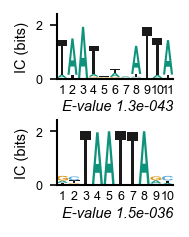

In [212]:
fig, axes = plt.subplots(figsize=(1,1.8), nrows=4, dpi=150, #constrained_layout=True,
                         gridspec_kw=dict(height_ratios=[2,1,2,1], hspace=0.1))

for i, name in enumerate(["Khom_atacGain.STREME-1","Khom_atacGain.STREME-2"]):

    pwm_ax = axes[2*i]
    #pwm_ax.axis("off")
    #pwm_ax.set_frame_on(False)
    pwm = atac_meme_pwms[name].copy()
    # get reverse complement
    #pwm = specseq_ewm_utils.get_motif_revcomp(pwm)
    # strip the pwm to match 11bp dimeric motif
    if i==0:
        pwm = pwm.loc[range(2,13,1),:].reset_index(drop=True)
        pwm["pos"] = pwm.index+1
        pwm = pwm.set_index("pos")
    fig, pwm_ax, pwm_logo = specseq_plot_utils.make_pwm_logo(pwm, sequence_design=None, add_filler=False, figax=(fig, pwm_ax))
    pwm_ax.set_ylim(bottom=0, top=2.4)
    pwm_ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    #pwm_ax.xaxis.set_visible(False)
    #pwm_ax.yaxis.set_visible(False)
    #[s.set_visible(False) for s in pwm_ax.spines.values()]
    # Hide the right and top spines
    pwm_ax.spines[['right', 'top']].set_visible(False)
    pwm_ax.spines[['left', 'bottom']].set_visible(True)
    pwm_ax.set_ylabel("IC (bits)")

    # add STREME stats
    stats_text = atac_meme_stats[name]
    stats_ax = axes[2*i+1]
    stats_ax.axis("off")
    stats_ax.text(1,.5, f"E-value {stats_text}", fontsize=mpl.rcParams["axes.titlesize"], style="italic", va="top", ha="right")

In [213]:
specseq_plot_utils.save_fig(fig, prefix=os.path.join(outbase_dir, "manuscript", "figure7_k88n_gain_pwm"), timestamp=False, tight_layout=False)

Text(1, 0.1, 'E-value 1.1e-010')

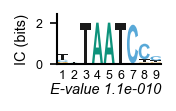

In [196]:
name = "Khom_atacLost.STREME-1"

fig, axes = plt.subplots(figsize=(.9,.6), nrows=2, dpi=150, #constrained_layout=True,
                         gridspec_kw=dict(height_ratios=[3,1], hspace=0.1))

pwm_ax = axes[0]
#pwm_ax.axis("off")
#pwm_ax.set_frame_on(False)
pwm = atac_meme_pwms[name].copy()
# get reverse complement
pwm = specseq_ewm_utils.get_motif_revcomp(pwm)
fig, pwm_ax, pwm_logo = specseq_plot_utils.make_pwm_logo(pwm, sequence_design=None, add_filler=False, figax=(fig, pwm_ax))
pwm_ax.set_ylim(bottom=0, top=2.4)
pwm_ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
#pwm_ax.xaxis.set_visible(False)
#pwm_ax.yaxis.set_visible(False)
#[s.set_visible(False) for s in pwm_ax.spines.values()]
# Hide the right and top spines
pwm_ax.spines[['right', 'top']].set_visible(False)
pwm_ax.spines[['left', 'bottom']].set_visible(True)
pwm_ax.set_ylabel("IC (bits)")

# add STREME stats
stats_text = atac_meme_stats[name]
stats_ax = axes[1]
stats_ax.axis("off")
stats_ax.text(1,.1, f"E-value {stats_text}", fontsize=mpl.rcParams["axes.titlesize"], style="italic", va="top", ha="right")

In [197]:
specseq_plot_utils.save_fig(fig, prefix=os.path.join(outbase_dir, "manuscript", "figure6_k88n_lost_pwm"), timestamp=False, tight_layout=False)

Text(1, 0.1, 'E-value 4.8e-016')

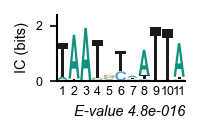

In [31]:
name = "Khet_atacGain.STREME-1"

fig, axes = plt.subplots(figsize=(1.1,.8), nrows=2, dpi=150, #constrained_layout=True,
                         gridspec_kw=dict(height_ratios=[3,1], hspace=0.1))

pwm_ax = axes[0]
#pwm_ax.axis("off")
#pwm_ax.set_frame_on(False)
pwm = atac_meme_pwms[name].copy()
# get reverse complement
#pwm = specseq_ewm_utils.get_motif_revcomp(pwm)
# strip the last three positions with low information contents
pwm = pwm.iloc[range(11),:]
fig, pwm_ax, pwm_logo = specseq_plot_utils.make_pwm_logo(pwm, sequence_design=None, add_filler=False, figax=(fig, pwm_ax))
pwm_ax.set_ylim(bottom=0, top=2.4)
pwm_ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
#pwm_ax.xaxis.set_visible(False)
#pwm_ax.yaxis.set_visible(False)
#[s.set_visible(False) for s in pwm_ax.spines.values()]
# Hide the right and top spines
pwm_ax.spines[['right', 'top']].set_visible(False)
pwm_ax.spines[['left', 'bottom']].set_visible(True)
pwm_ax.set_ylabel("IC (bits)")

# add STREME stats
stats_text = atac_meme_stats[name]
stats_ax = axes[1]
stats_ax.axis("off")
stats_ax.text(1,.1, f"E-value {stats_text}", fontsize=mpl.rcParams["axes.titlesize"], style="italic", va="top", ha="right")

In [32]:
specseq_plot_utils.save_fig(fig, prefix=os.path.join(outbase_dir, "manuscript", "figure6supp_khet_gain_pwm"), timestamp=False, tight_layout=False)

#### De novo found PWM that resembles neurogenic TF motifs

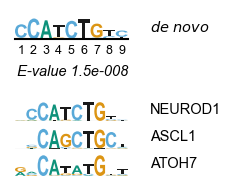

In [230]:
fig, axes = plt.subplots(figsize=(1.6,1.4), nrows=6, ncols=2, dpi=150, #constrained_layout=True,
                         gridspec_kw=dict(width_ratios=[2,1], height_ratios=[1]*6, hspace=0.1))

pwm_ax = axes[0,0]
pwm = atac_meme_pwms["Khom_atacGain.STREME-7"].copy()
# get reverse complement
#pwm = specseq_ewm_utils.get_motif_revcomp(pwm)
fig, pwm_ax, pwm_logo = specseq_plot_utils.make_pwm_logo(pwm, sequence_design=None, add_filler=False, figax=(fig, pwm_ax))
pwm_ax.set_ylim(bottom=0, top=2.4)
pwm_ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
#pwm_ax.xaxis.set_visible(False)
pwm_ax.yaxis.set_visible(False)
#[s.set_visible(False) for s in pwm_ax.spines.values()]
# Hide the right and top spines
pwm_ax.spines[['right', 'top', 'left']].set_visible(False)
pwm_ax.spines[['bottom']].set_visible(True)
pwm_ax.set_ylabel("")
axes[0,1].text(.1, .5, "$\it de$ $\it novo$", fontsize=mpl.rcParams["axes.titlesize"], va="center", ha="left")

# add STREME stats
stats_text = atac_meme_stats["Khom_atacGain.STREME-7"]
stats_ax = axes[1,0]
stats_ax.axis("off")
stats_ax.text(1,.1, f"E-value {stats_text}", fontsize=mpl.rcParams["axes.titlesize"], style="italic", va="top", ha="right")

axes[0,1].axis("off")
axes[1,1].axis("off")
axes[2,0].axis("off")
axes[2,1].axis("off")


for i, name in enumerate(["NEUROD1_HUMAN.MA1109.1","ASCL1_HUMAN.MA1100.1","ATOH7_HUMAN.MA1468.1"]):
    pwm_ax = axes[i+3,0]
    pwm_ax.axis("off")
    pwm_ax.set_frame_on(False)
    pwm = prtf_meme_pwms[name].copy()
    # get reverse complement
    pwm = specseq_ewm_utils.get_motif_revcomp(pwm)
    # pad the ASCL1 pwm
    if "ASCL1" in name:
        pwm = pd.concat([pd.DataFrame(pd.Series({"A":0.25,"C":0.25,"G":0.25,"T":0.25})).T, pwm], axis=0)
        pwm["pos"] = pwm.index+1
        pwm = pwm.set_index("pos")
    fig, pwm_ax, pwm_logo = specseq_plot_utils.make_pwm_logo(pwm, sequence_design=None, add_filler=False, figax=(fig, pwm_ax))
    pwm_ax.set_ylim(bottom=0, top=2.4)
    pwm_ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    #pwm_ax.xaxis.set_visible(False)
    #pwm_ax.yaxis.set_visible(False)
    [s.set_visible(False) for s in pwm_ax.spines.values()]
    # display the TF name
    axes[i+3,1].axis("off")
    axes[i+3,1].text(.1, .5, name.split("_")[0], fontsize=mpl.rcParams["axes.labelsize"], va="center", ha="left")

In [231]:
specseq_plot_utils.save_fig(fig, prefix=os.path.join(outbase_dir, "manuscript", "figure7_k88n_gain_Nueropwm"), timestamp=False, tight_layout=False)

#### overlapped with VSX2 ChIP peaks

In [219]:
### find intersection between CRX chip and vsx2 e14.5 chip
crx_chip_df = k88n_atac_intersect_df[['k88n.peak.id', 'k88n.seqnames', 'k88n.start', 'k88n.end',
       'nn_atac_cluster', 'nt_atac_cluster', 'ww_atac_cluster']].copy()

# intersect chip and atac peaks
k88n_atac_vsx2_intersect_df = chipseq_annotation_utils.bedtools_intersect_and_compile(crx_chip_df[['k88n.seqnames', 'k88n.start', 'k88n.end']],
                                                vsx2_consensus_peakset[["seqnames","start","end"]],
                                                query_prefix="k88n", subject_prefix="vsx2")
k88n_atac_vsx2_intersect_df = k88n_atac_vsx2_intersect_df.astype(object)

# attach crx e80a atac data
k88n_atac_vsx2_intersect_df = crx_chip_df.merge(k88n_atac_vsx2_intersect_df, \
                            on=[f"k88n.seqnames",f"k88n.start",f"k88n.end"], how="left")
# attach nrl cut&run data
k88n_atac_vsx2_intersect_df = k88n_atac_vsx2_intersect_df.merge(vsx2_consensus_peakset, \
                            left_on=[f"vsx2.seqnames",f"vsx2.start",f"vsx2.end"], right_on=["seqnames","start","end"], how="left").\
                            drop(columns=["seqnames","start","end"]).rename(columns={"ints_cluster":"vsx2_cluster"})

del(crx_chip_df)

display(k88n_atac_vsx2_intersect_df .groupby(["nn_atac_cluster","vsx2_cluster"])["k88n.peak.id"].count().unstack())

vsx2_cluster,adult,e14.5,notDB
nn_atac_cluster,,,
nn.atac.gain,222,437,432
nn.atac.lost,71,10,14
nn.atac.notDA,5177,3100,3494


In [225]:
# incorporated in chipseq_annotation_utils.py
import statsmodels.api as sm
def grouped_exact_tests(contigency_table, use_test="fisher", alternative="two-sided"):
    # prepare the data
    summary_tb = contigency_table.copy()

    # barnard's
    if use_test == "barnard":
        res = stats.barnard_exact(summary_tb, alternative=alternative)
        return(res.pvalue)

    # fisher's - default
    else:
        res = stats.fisher_exact(summary_tb, alternative=alternative)
        return(res[1])

def odds_ratio_by_Gp(contigency_table, uselog=True):
    # prepare the data
    summary_tb = contigency_table.copy()

    # create a statsmodels Table object
    or_table = sm.stats.Table(summary_tb)
    # retrieve odds ratio
    if uselog:
        odds_ratio = or_table.local_log_oddsratios.iloc[0,0]
    else:
        odds_ratio = or_table.local_oddsratios.iloc[0,0]

    return odds_ratio

In [226]:
# calculate odds ratios and fisher's exact test p-value
k88n_vsx2_count_df = pd.Series(dtype=object)
for i,change in enumerate(["adult","e14.5","notDB"]):
    count_df = np.array([[0,0],[0,0]])
    count_df[0,0] = k88n_atac_vsx2_intersect_df.groupby(["nn_atac_cluster","vsx2_cluster"])["k88n.peak.id"].count().unstack().loc["nn.atac.gain",change] # k88n gained and e14.5
    count_df[1,0] = k88n_atac_intersect_df["nn_atac_cluster"].value_counts()["nn.atac.gain"]-count_df[0,0] # k88n gained but not e14.5
    count_df[0,1] = k88n_atac_vsx2_intersect_df.groupby(["nn_atac_cluster","vsx2_cluster"])["k88n.peak.id"].count().unstack().iloc[[1,2],i].sum() # e14.5 but not k88n gained
    count_df[1,1] = k88n_atac_intersect_df["nn_atac_cluster"].count()-k88n_atac_intersect_df["nn_atac_cluster"].value_counts()["nn.atac.gain"]-count_df[0,1] # chip peaks not k88n gained nor e14.5
    display(count_df)
    k88n_vsx2_count_df[change] = count_df

contigency_table_ser = pd.Series(k88n_vsx2_count_df.apply(lambda count_df: pd.DataFrame(count_df, index=["pos","neg"], columns=["gp1","gp2"])), index=k88n_vsx2_count_df.index)
# fisher p, barnard p, odds ratio, fisher padj, barnard adj
all_stats = np.empty((len(contigency_table_ser.index),2),dtype=object)
all_stats[:,0] = contigency_table_ser.apply(lambda tb: odds_ratio_by_Gp(tb, uselog=True))
all_stats[:,1] = contigency_table_ser.apply(lambda tb: grouped_exact_tests(tb, use_test="fisher"))

# construct dataframe from the numpy array
differential_enrichement_stats = pd.DataFrame(all_stats, columns=["log odds ratio", "fisher's p"], index=contigency_table_ser.index)
differential_enrichement_stats["odds ratio"] = differential_enrichement_stats["log odds ratio"].apply(lambda x: np.exp(x))

display(differential_enrichement_stats)

array([[   222,   5248],
       [  6995, 108843]])

array([[   437,   3110],
       [  6780, 110981]])

array([[   432,   3508],
       [  6785, 110583]])

,log odds ratio,fisher's p,odds ratio
adult,-0.418214,0.0,0.658221
e14.5,0.832937,0.0,2.300064
notDB,0.696676,0.0,2.007071


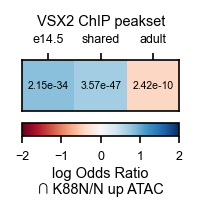

In [227]:
# make the differential enrichement into a heatmap
# set up the figure
fig = plt.figure(figsize=(1.2,1.3), constrained_layout=True, dpi=150)
gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[4,1])
gs.update(left=0.1,right=0.95,top=0.95,bottom=0.05,wspace=0.01) #padding for each grid space

# frequency heatmap
ax = fig.add_subplot(gs[0])
vmax = 0.4
annot_df = differential_enrichement_stats.reindex(["e14.5","notDB","adult"])[["log odds ratio"]].astype(float).T
heatmap = ax.imshow(annot_df, aspect="auto", vmin=-2, vmax=2, cmap="RdBu")
ax.xaxis.set_ticks_position("top")
ax.set_xticks(np.arange(len(annot_df.columns)))
ax.set_xticklabels(["e14.5","shared","adult"])
ax.set_yticks([])
ax.set_title("VSX2 ChIP peakset")

# annotation fisher's exact text p values
ax.text(0, 0, f"{differential_enrichement_stats.iloc[2,1]:.2e}", ha="center", va="center", color="black")
ax.text(1, 0, f"{differential_enrichement_stats.iloc[1,1]:.2e}", ha="center", va="center", color="black")
ax.text(2, 0, f"{differential_enrichement_stats.iloc[0,1]:.2e}", ha="center", va="center", color="black")

# Add a colorbar
cbar_ax = fig.add_subplot(gs[1])
colorbar = fig.colorbar(heatmap, cax=cbar_ax, label="log Odds Ratio\n∩ K88N/N up ATAC", orientation="horizontal")
cbar_ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))


In [228]:
specseq_plot_utils.save_fig(fig, prefix=os.path.join(outbase_dir, "manuscript", "figure7_k88n_gain_vsx2chipOR"), timestamp=False, tight_layout=False)

#### GO term barcharts

In [364]:
def get_topN_GOterms(GOtable,top_n=5):
    # check if the GOtable contains top_n entries
    # if not, return all entries
    if len(GOtable.index) > int(top_n):
        top_df = GOtable.sort_values("p.adjust", ascending=True).head(top_n)
    else:
        top_df = GOtable.sort_values("p.adjust", ascending=True)

    return top_df

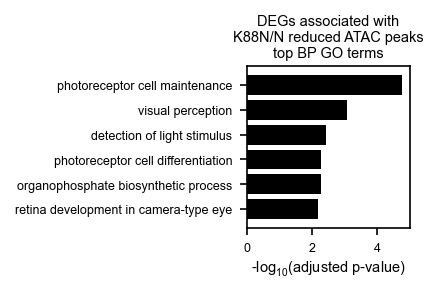

In [373]:
# read GO enrichment table
GOenrich_df = pd.read_csv(os.path.join(atac_basedir, "nn.lost_p10_GOTERM_BP.DEGs.tsv"), sep="\t", header=0)

# fetch the top n GO terms to plot
GOenrich_df_toplot = get_topN_GOterms(GOenrich_df,top_n=7)
#display(GOenrich_df_toplot)

# drop the viral process term
GOenrich_df_toplot = GOenrich_df_toplot.drop(index=1)

# convert padj to -log10 scale
GOenrich_df_toplot["-log10padj"] = -np.log10(GOenrich_df_toplot["p.adjust"])

# setup figure
fig, ax = plt.subplots(figsize=(1.4,1.4), dpi=150)
ax = sns.barplot(data=GOenrich_df_toplot, x="-log10padj", y="Description", color="k", dodge=False, ax=ax)

# give it some space on the top and bottom
ax.set_ylim(ax.get_ylim()[0]+.25,ax.get_ylim()[1]-.25)

ax.set_title(f"DEGs associated with\nK88N/N reduced ATAC peaks\ntop BP GO terms")
ax.set_xlabel("-$log_{10}$(adjusted p-value)")
ax.set_ylabel("")
ax.legend([],[],frameon=False) # remove legend

In [374]:
specseq_plot_utils.save_fig(fig, prefix=os.path.join(outbase_dir, "manuscript", "figure6_k88n_lost_GOenrichment"), timestamp=False, tight_layout=False)

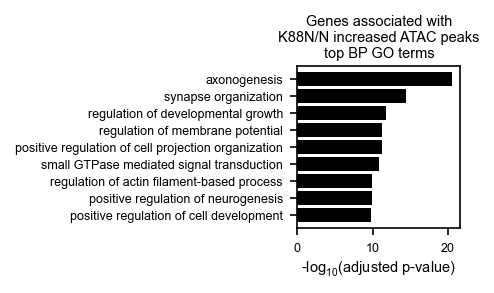

In [381]:
# read GO enrichment table
GOenrich_df = pd.read_csv(os.path.join(atac_basedir, "nn.gain_p10_GOTERM_BP.allGenes.tsv"), sep="\t", header=0)

# fetch the top n GO terms to plot
GOenrich_df_toplot = get_topN_GOterms(GOenrich_df,top_n=10)
#display(GOenrich_df_toplot)

# drop the muscle process term
GOenrich_df_toplot = GOenrich_df_toplot.drop(index=6)

# convert padj to -log10 scale
GOenrich_df_toplot["-log10padj"] = -np.log10(GOenrich_df_toplot["p.adjust"])

# setup figure
fig, ax = plt.subplots(figsize=(1.4,1.4), dpi=150)
ax = sns.barplot(data=GOenrich_df_toplot, x="-log10padj", y="Description", color="k", dodge=False, ax=ax)

# give it some space on the top and bottom
ax.set_ylim(ax.get_ylim()[0]+.25,ax.get_ylim()[1]-.25)

ax.set_title(f"Genes associated with\nK88N/N increased ATAC peaks\ntop BP GO terms")
ax.set_xlabel("-$log_{10}$(adjusted p-value)")
ax.set_ylabel("")
ax.legend([],[],frameon=False) # remove legend

In [383]:
specseq_plot_utils.save_fig(fig, prefix=os.path.join(outbase_dir, "manuscript", "figure7_k88n_gain_GOenrichment"), timestamp=False, tight_layout=False)

#### Developmental dynamics lineplots of K88N differential ATAC peaks

In [23]:
# developmental atac pattern at E80A differential peaks
# convert aldiri atac count matrix to rowz
### row z-score transform the scATAC matrix
tmp = k88n_atac_aldiri.iloc[:, range(7,13)].T.copy().astype(np.float64)
# sklearn https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
scaler = StandardScaler()
# fit the data
scaler.fit(tmp)
# Perform standardization by centering and scaling.
tmp_rowz_array = scaler.transform(tmp)

# convert the rowz array to dataframe
tmp_rowz = pd.DataFrame(tmp_rowz_array).T
tmp_rowz.columns = tmp.index
tmp_rowz.index = tmp.columns
tmp_rowz["mean"] = scaler.mean_
tmp_rowz["variance"] = scaler.var_

# calculate the coefficient of variation cov = std/mean
tmp_rowz["cov"] = scipy.stats.variation(tmp, axis=0, nan_policy='propagate', ddof=1, keepdims=False)
    
# attach the annotation
k88n_aldiri_normalized_rowz = pd.concat([k88n_atac_aldiri.iloc[:, range(5)], tmp_rowz], axis=1)


In [24]:
# attach k88n atac annotation
k88n_atac_aldiri_data = k88n_aldiri_normalized_rowz.rename(columns={"seqnames":"k88n.seqnames","start":"k88n.start","end":"k88n.end"}).\
                        merge(k88n_atac_intersect_df[["k88n.peak.id","k88n.seqnames","k88n.start","k88n.end","nn_atac_cluster"]], how="right")
                                                    

k88n_atac_aldiri_data.replace([np.inf, -np.inf], np.nan, inplace=True)
k88n_atac_aldiri_data = k88n_atac_aldiri_data.dropna()

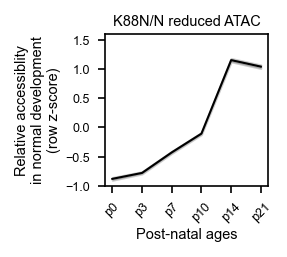

In [25]:
fig, ax = plt.subplots(figsize=(1.8,1.6), dpi=150, constrained_layout=True)

# reshape data
data_to_plot = k88n_atac_aldiri_data.loc[lambda df: df["nn_atac_cluster"] == "nn.atac.lost",:].copy().reset_index(drop=True)
# convert wide to long dataframe
data_to_plot = pd.melt(data_to_plot, id_vars=["k88n.peak.id"], value_vars=[f"wt_{age}_atac" for age in ["p0","p3","p7","p10","p14","p21"]], var_name="age", value_name="norm.counts")
# order the ages to make sure they match of that specified
data_to_plot["age"] = data_to_plot["age"].astype(CategoricalDtype(categories=[f"wt_{age}_atac" for age in ["p0","p3","p7","p10","p14","p21"]], ordered=True))


plot_parameters = dict(
        xlabel = "Post-natal ages",
        ylabel = "Relative accessiblity\nin normal development\n(row z-score)",
        x_column="age",
        y_column="norm.counts"
    )

fig, ax =  rnaseq_plot_utils.single_line_by_category(data=data_to_plot, color="black", **plot_parameters, figax=(fig,ax))

plot_ages=["p0","p3","p7","p10","p14","p21"]
ax.set_ylim(-1,1.6) 
ax.set_title("K88N/N reduced ATAC") 
ax.set_xticks(range(len(plot_ages)), plot_ages, rotation=45)

In [26]:
specseq_plot_utils.save_fig(fig, prefix=os.path.join(outbase_dir, "manuscript", "figure6_k88n_down_aldiri_atac"), timestamp=False, tight_layout=False)

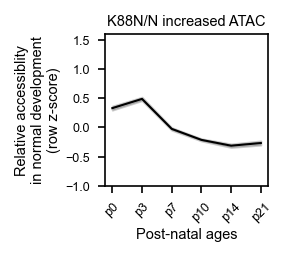

In [27]:
fig, ax = plt.subplots(figsize=(1.8,1.6), dpi=150, constrained_layout=True)

# reshape data
data_to_plot = k88n_atac_aldiri_data.loc[lambda df: df["nn_atac_cluster"] == "nn.atac.gain",:].copy().reset_index(drop=True)
# convert wide to long dataframe
data_to_plot = pd.melt(data_to_plot, id_vars=["k88n.peak.id"], value_vars=[f"wt_{age}_atac" for age in ["p0","p3","p7","p10","p14","p21"]], var_name="age", value_name="norm.counts")
# order the ages to make sure they match of that specified
data_to_plot["age"] = data_to_plot["age"].astype(CategoricalDtype(categories=[f"wt_{age}_atac" for age in ["p0","p3","p7","p10","p14","p21"]], ordered=True))


plot_parameters = dict(
        xlabel = "Post-natal ages",
        ylabel = "Relative accessiblity\nin normal development\n(row z-score)",
        x_column="age",
        y_column="norm.counts"
    )

fig, ax =  rnaseq_plot_utils.single_line_by_category(data=data_to_plot, color="black", **plot_parameters, figax=(fig,ax))

plot_ages=["p0","p3","p7","p10","p14","p21"]
ax.set_ylim(-1,1.6) 
ax.set_title("K88N/N increased ATAC") 
ax.set_xticks(range(len(plot_ages)), plot_ages, rotation=45)

In [28]:
specseq_plot_utils.save_fig(fig, prefix=os.path.join(outbase_dir, "manuscript", "figure7_k88n_up_aldiri_atac"), timestamp=False, tight_layout=False)

#### P10 RNAseq strip and box plot of CRX target genes mapped to K88N/N down ATAC peaks

In [53]:
grouped_genelist

,Gene,GENEID,Name,Group
0,Grk1,ENSMUSG00000031450,G protein-coupled receptor kinase 1(Grk1),Group1
1,Optn,ENSMUSG00000026672,optineurin(Optn),Group1
2,Kirrel,ENSMUSG00000041734,kirre like nephrin family adhesion molecule 1(...,Group1
3,Gngt1,ENSMUSG00000029663,guanine nucleotide binding protein (G protein)...,Group1
4,Cplx4,ENSMUSG00000024519,complexin 4(Cplx4),Group1
...,...,...,...,...
181,Lmnb1,ENSMUSG00000024590,lamin B1(Lmnb1),Group2
182,Ppef2,ENSMUSG00000029410,"protein phosphatase, EF hand calcium-binding d...",Group2
183,Eno2,ENSMUSG00000004267,"enolase 2, gamma neuronal(Eno2)",Group2
184,Pde6h,ENSMUSG00000064330,"phosphodiesterase 6H, cGMP-specific, cone, gam...",Group2


In [120]:
order = list("p10."+pd.Series(["rhom","khet","khom"])+".lfc")
nn_p10_lost_genes = pd.read_csv(os.path.join(atac_basedir, "nn_lost_atac_p10_DEGs.forDAVID.tsv"), sep="\t", header=0)
nn_p10_lost_genes = nn_p10_lost_genes.merge(crx_rna_full_matrix[["GENENAME"]+order]).dropna()
nn_p10_lost_genes = nn_p10_lost_genes.drop_duplicates(subset="GENENAME").reset_index(drop=True)
# only CRX-DAGs
#nn_p10_lost_genes = nn_p10_lost_genes.loc[lambda df: df["GENENAME"].isin(grouped_genelist["Gene"]),:].reset_index(drop=True)
# logFC cutoff
nn_p10_lost_genes = nn_p10_lost_genes.loc[lambda df: df["p10.khom.lfc"]<=-np.log2(1.5),:].reset_index(drop=True)
# convert wide to long dataframe
data_to_plot = pd.melt(nn_p10_lost_genes, id_vars=["GENENAME"], value_vars=order, var_name="genotype", value_name="log.fc")

Text(0.5, 1.0, 'DEGs associated with\nK88N/N reduced\nATAC peaks')

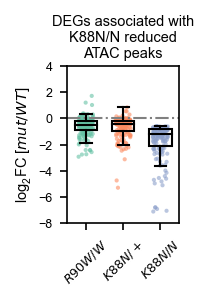

In [121]:
# set up the figure
fig = plt.figure(figsize=(1.2,1.9), constrained_layout=True, dpi=150)
gs = fig.add_gridspec(nrows=1, ncols=1, width_ratios=[1], height_ratios=[1])
gs.update(top=0.95,bottom=0.1,wspace=0.00,hspace=0.00) #padding for each grid space

ax = fig.add_subplot(gs[0])

plot_parameters = dict(
        xlabel = "",
        ylabel = f"$log_{2}$FC [$\it mut/WT$]",
        x_column="genotype",
        y_column="log.fc",
    )

box_props = {
    'boxprops':{'edgecolor':'black', 'facecolor':'none', 'alpha': 1, 'zorder': 10}, #'facecolor':'none',
    'medianprops':{'color':'black','alpha': 1, },
    'whiskerprops':{'color':'black','alpha': 1, },
    'capprops':{'color':'black','alpha': 1, },
}

ax = sns.boxplot(x="genotype", y="log.fc", data=data_to_plot,
                        order=order, palette="Set2",
                        width=.6, linewidth=1.0, showfliers=False,
                        orient="v", ax=ax, zorder=10,
                        **box_props
    )
ax = sns.stripplot(x="genotype", y="log.fc", data=data_to_plot, dodge=False, palette="Set2", edgecolor="none", alpha=.6,
                   linewidth=1, marker=".", size=4, jitter=.2, ax=ax, zorder=0)

ax.hlines(y=0,xmin=-.5,xmax=2.5,linestyles="-.",color="grey")
ax.set_xticks(range(3))
ax.set_xticklabels([f"$\it {name}$" for name in ["R90W/W", "K88N/+", "K88N/N"]], rotation=45)
ax.set_xlabel("")
ax.set_ylim(-8,4)
ax.set_ylabel(f"$log_{2}$FC [$\it mut/WT$]")
ax.set_title("DEGs associated with\nK88N/N reduced\nATAC peaks")

In [122]:
specseq_plot_utils.save_fig(fig, prefix=os.path.join(outbase_dir, "manuscript", "figure6_k88n_lost_atac_DEGs"), timestamp=False, tight_layout=False)

In [123]:
# hierarchical clustering of the lfc expression matrix 
crxdepAct_rna_lfc_cg = chipseq_plot_utils.chip_intensity_heatmap(data=nn_p10_lost_genes.iloc[:,[2,3,4]].astype(float).copy(), 
                                                                 hm_title=None, hm_xlabel=None, cb_title=None, cmap=div_heat_colors, 
                                                                 paramdict=dict(
                                                                        z_score=0, # z normalized by row
                                                                        metric="euclidean", # plot with euclidean distance
                                                                        method="complete", # linkage method to use for calculating clusters
                                                                        ))
crxdepAct_rna_lfc_cg.ax_row_dendrogram.set_visible(True)
new_order = crxdepAct_rna_lfc_cg.dendrogram_row.reordered_ind
plt.close()

# reorder the lfc dataframe based on clustering
reordered_crxdepAct_rna_lfc = nn_p10_lost_genes.iloc[new_order,:].reset_index(drop=True)
# reverse the order so that up-regulated genes are on top
reordered_crxdepAct_rna_lfc = reordered_crxdepAct_rna_lfc.loc[::-1].reset_index(drop=True)

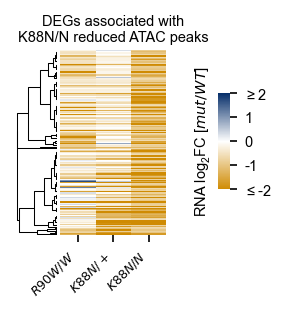

In [124]:
# Panel 4b. expression heatmap with dendrogram
# set up the figure
fig, ax_list = plt.subplots(ncols=3, figsize=(1.6,1.6), dpi=150, constrained_layout=False, gridspec_kw=dict(width_ratios=[.4,1,.3], wspace=.05))
heatmap_ax = ax_list[1]

# make the log2FC heatmap
heatmap_ax = sns.heatmap(data=reordered_crxdepAct_rna_lfc.iloc[:,[2,3,4]].astype(float), ax=heatmap_ax, cmap=div_heat_colors, vmin=-2, vmax=2, cbar=False)
heatmap_ax.set_yticks([])
        
heatmap_ax.set_xticklabels([f"$\it {name}$" for name in ["R90W/W", "K88N/+", "K88N/N"]], rotation=45, ha="right", va="top")
heatmap_ax.yaxis.set_visible(False)
#gene_num = len(reordered_crxdepAct_rna_lfc.index)
heatmap_ax.set_title("DEGs associated with\nK88N/N reduced ATAC peaks")


# plot the dendrogram on the left
dendro_ax = ax_list[0]

hierarchy.set_link_color_palette(["k"])
# Override the default linewidth.
mpl.rcParams['lines.linewidth'] = 0.5
decdro_dict = scipy.cluster.hierarchy.dendrogram(Z=crxdepAct_rna_lfc_cg.dendrogram_row.linkage, ax = dendro_ax, distance_sort="ascending", orientation="left", above_threshold_color='k')
dendro_ax.yaxis.set_visible(True)
dendro_ax.yaxis.set_ticks([])
dendro_ax.xaxis.set_visible(False)
dendro_ax.set_frame_on(False)



# reset to default after use
hierarchy.set_link_color_palette(None)
mpl.rcParams['lines.linewidth'] = 1.0

# add color bar separately
ax_list[2].axis("off")
cbar_ax = plt.axes([.97, .3, 0.05, 0.4])
cbar_ax.set_frame_on(False)
norm = mpl.colors.Normalize(vmin=-2, vmax=2)
colorbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=div_heat_colors), ticks=[-2,-1,0,1,2],
        cax=cbar_ax, orientation='vertical')
ticks = cbar_ax.get_yticks()
ticks = [f"{i:.0f}" for i in ticks]
ticks[-1] = r"$\geq$" + ticks[-1]
ticks[0] = r"$\leq$" + ticks[0]
cbar_ax.set_yticklabels(ticks)
cbar_ax.text(-.4,0, f"RNA $log_{2}$FC [$\it mut/WT$]", rotation=90, fontsize=mpl.rcParams['axes.titlesize'], va="center", ha="right")
cbar_ax.tick_params(labelsize=7, rotation=0)


In [125]:
specseq_plot_utils.save_fig(fig, prefix=os.path.join(outbase_dir, "manuscript", "figure6_k88n_lost_atac_DEGs_heatmap"), timestamp=False, tight_layout=False)

#### Miscellaneous plots

- Figure4a schematics

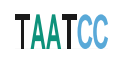

In [249]:
fig, pwm_ax = plt.subplots(figsize=(.8,.3),  dpi=150)

pwm = [[0,0,0,1],
       [1,0,0,0],
       [1,0,0,0],
       [0,0,0,1],
       [0,1,0,0],
       [0,1,0,0]]
pwm = pd.DataFrame(pwm, index=range(1,7,1), columns=["A","C","G","T"])

fig, pwm_ax, pwm_logo = specseq_plot_utils.make_pwm_logo(pwm, sequence_design=None, add_filler=False, figax=(fig, pwm_ax))
pwm_ax.set_ylim(bottom=0, top=2)
pwm_ax.xaxis.set_visible(False)
pwm_ax.yaxis.set_visible(False)
[s.set_visible(False) for s in pwm_ax.spines.values()]

specseq_plot_utils.save_fig(fig, prefix=os.path.join(outbase_dir, "manuscript", "figure3_k50mono_pwmCartoon"), timestamp=False, tight_layout=False)


in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...


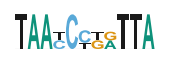

In [8]:
fig, pwm_ax = plt.subplots(figsize=(1.2,.3),  dpi=150)

pwm = [[0,0,0,1],
       [1,0,0,0],
       [1,0,0,0],
       [0,1,0,1],
       [0,1,0,0],
       [0,2,0,1],
       [0,0,1,1],
       [1,0,1,0],
       [0,0,0,1],
       [0,0,0,1],
       [1,0,0,0]]
pwm = pd.DataFrame(pwm, index=range(1,12,1), columns=["A","C","G","T"])

fig, pwm_ax, pwm_logo = specseq_plot_utils.make_pwm_logo(pwm, sequence_design=None, add_filler=False, figax=(fig, pwm_ax))
pwm_ax.set_ylim(bottom=0, top=2)
pwm_ax.xaxis.set_visible(False)
pwm_ax.yaxis.set_visible(False)
[s.set_visible(False) for s in pwm_ax.spines.values()]

specseq_plot_utils.save_fig(fig, prefix=os.path.join(outbase_dir, "manuscript", "figure3_k50dimer_pwmCartoon"), timestamp=False, tight_layout=False)
